# Calcul sur GPU :

*sur Google Colab :*
*Runtime -> Change Runtime Type -> GPU*

Pour travailler sur son propre GPU NVIDIA, avec VS Code :
1) mettre à jour son pilote via GeForce Experience
2) avoir VS Code
3) installer la dernière version de CUDA Toolkit https://developer.nvidia.com/cuda-toolkit-archive
4) sur https://pytorch.org/get-started/locally/ trouver la commande pour charger torch en gpu, par exemple pour nous, sur windows avec la dernière version de CUDA toolkit on utilise : !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 

In [1]:
!pip install torch torchvision
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 
# changer la ligne ci dessus, cf étape 4

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu121


# Charger les bibliothèques

In [2]:
import platform
print(f"Python version: {platform.python_version()}")

import torch
torch.cuda.is_available() # gpu détecté

Python version: 3.12.2


True

In [3]:
# import the packages
import numpy as np
from PIL import Image
from IPython.display import clear_output
import matplotlib.pyplot as plt
import math
import os
import inspect  # debugage

# import PyTorch (Deep Learning lib)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms


# Création des dossiers

Un dossier où sera enregistré les paramètres des modèles (fichiers .pth) et un dossier pour les figures (fichiers .png).

In [4]:
if not os.path.exists('./models'):
    os.makedirs('./models')

if not os.path.exists('./figures'):
    os.makedirs('./figures')

# Outils Python



### **class DataLoader** :

La classe suivante permet de charger les données (CIFAR10 ou CIFAR100) en fonction du batch_size.

L’entraînement utilisera data.trainloader. 
La classe permet aussi différents affichage des données.

L'attribut self.transform est une normalisation des données, qui sera expliquée par la suite.

In [5]:
class DataLoader:
    
    def __init__(self, batch_size, cifar = None):
        self.batch_size = batch_size
        self.transform = transforms.Compose(
            [transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        if cifar == 10:
            self._load_cifar10()
            self._distrib_figsize = (6,6)
        elif cifar == 100:
            self._load_cifar100()
            self._distrib_figsize = (6,15)
        else:
            print("argument 'cifar' invalide, choisir parmi '10' ou '100'")

    def _load_cifar10(self):
        self.trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                download=True, transform=self.transform)
        self.trainloader = torch.utils.data.DataLoader(self.trainset, batch_size=self.batch_size,
                                                shuffle=True, num_workers=2)
        self.testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=self.transform)
        self.testloader = torch.utils.data.DataLoader(self.testset, batch_size=self.batch_size,
                                                shuffle=False, num_workers=2)
        self.classes = ('plane', 'car', 'bird', 'cat', 'deer', 
                        'dog', 'frog', 'horse', 'ship', 'truck')
    def _load_cifar100(self):
        self.trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                                download=True, transform=self.transform)
        self.trainloader = torch.utils.data.DataLoader(self.trainset, batch_size=self.batch_size,
                                                shuffle=True, num_workers=2)
        self.testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                            download=True, transform=self.transform)
        self.testloader = torch.utils.data.DataLoader(self.testset, batch_size=self.batch_size,
                                                shuffle=False, num_workers=2)
        self.classes = ("apple", "aquarium_fish", "baby", "bear", "beaver", "bed", "bee", "beetle",
                        "bicycle", "bottle", "bowl", "boy", "bridge", "bus", "butterfly", "camel",
                        "can", "castle", "caterpillar", "cattle", "chair", "chimpanzee", "clock",
                        "cloud", "cockroach", "couch", "cra", "crocodile", "cup", "dinosaur",
                        "dolphin", "elephant", "flatfish", "forest", "fox", "girl", "hamster",
                        "house", "kangaroo", "keyboard", "lamp", "lawn_mower", "leopard", "lion",
                        "lizard", "lobster", "man", "maple_tree", "motorcycle", "mountain", "mouse",
                        "mushroom", "oak_tree", "orange", "orchid", "otter", "palm_tree", "pear",
                        "pickup_truck", "pine_tree", "plain", "plate", "poppy", "porcupine", "possum",
                        "rabbit", "raccoon", "ray", "road", "rocket", "rose", "sea", "seal",
                        "shark", "shrew", "skunk", "skyscraper", "snail", "snake", "spider",
                        "squirrel", "streetcar", "sunflower", "sweet_pepper", "table", "tank",
                        "telephone", "television", "tiger", "tractor", "train", "trout", "tulip",
                        "turtle", "wardrobe", "whale", "willow_tree", "wolf", "woman", "worm")
    
    def show_class_distribution(self, train_or_test):
        if train_or_test.lower() == 'train':
            dataset = self.trainset
            set_name = "d'entraînement"
        elif train_or_test.lower() == 'test':
            dataset = self.testset
            set_name = "de test"
        class_counts = [0] * len(self.classes)
        for _, label in dataset:
            class_counts[label] += 1
        fig, ax = plt.subplots(figsize=self._distrib_figsize)
        ax.barh(self.classes, class_counts)
        ax.set_ylabel('Classes')
        ax.set_xlabel('Nombre d\'images')
        ax.set_title(f'Distribution des classes dans l\'ensemble {set_name}')
        plt.show()
        
    def get_random_train_batch(self):
        dataiter = iter(self.trainloader)
        images, labels = next(dataiter)
        return images, labels
    
    def show_one_random_batch(self):
        images, labels = self.get_random_train_batch()
        # show images
        self._imshow(torchvision.utils.make_grid(images))
        print(f"batch_size = {images.shape[0]} et dimension d'une image = {images.shape[1:]}")
        # print labels
        self._print_labels_as_grid(labels)

    def _imshow(self, img):
        img = img / 2 + 0.5     # unnormalize
        npimg = img.numpy()
        self._fig = plt.figure()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()
        
    def _print_labels_as_grid(self, labels):
        xlim = self._fig.get_axes()[0].get_xlim()
        ylim = self._fig.get_axes()[0].get_ylim()
        NX = int(np.abs( xlim[1] - xlim[0] ) / 32)
        NY = int(np.abs( ylim[1] - ylim[0] ) / 32)
        class_names = np.array(self.classes)
        labels_name = [class_names[label] for label in labels]
        for ny in range(NY):
            if ny == NY-1:
                print('\t'.join(labels_name[ny*NX:]))
            else:
                print('\t'.join(labels_name[ny*NX : (ny+1)*NX]))
    

### **class TrainEtPrecision** :

Cette classe lance directement l’entraînement d'un modèle, sur un nombre donnée d'epochs, et avec un critère et un optimizer au choix.

Elle enregistre ensuite les paramètres dans un fichier 'run_name.pth' ainsi que l'image avec l'évolution de la précision et de la loss pendant l’entraînement 'run_name.png'.

Le choix d'un faire une classe est pour améliorer la lisibilité de l'écriture du code, plutôt que d'avoir une énorme fonction ; et aussi pour pouvoir garder les valeurs d'un entrainement en memoire dans des objets instanciés pour chaque training. \
*Exemple :* \
*training1 = TrainEtPrecision(..., net1, ........., run1) permet d'avoir ainsi en mémoire la loss d'un training avec l'attribut training.LOSS*

In [6]:
class TrainEtPrecision:
    
    def __init__(self,
                data_loader,
                net,
                criterion,
                optimizer,
                n_epochs,
                run_name):
        self.data_loader = data_loader  # instance de la classe DataLoader 
        self.net = net                  # instance de la classe du modèle du reseau
        self.criterion = criterion      # critère d'optimisation
        self.optimizer = optimizer      # algo d'optimisation
        self.n_epochs = n_epochs        # nb d'epochs pour l’entraînement
        self.run_name = run_name        # nom de la figure et du modèle pour enregistrer les résultats :
                                            # l'image de la précision en .png full HD
                                            # les paramètres du réseau final en .pth
        # variables à plotter :
        self.LOSS = []
        self.accuracy_test = []
        self.accuracy_train = []
        
        # ENTRAÎNEMENT :
        for epoch in range(1, self.n_epochs+1):  # loop over the dataset multiple times
            print(f"EPOCH #{epoch}")
            # OPTIMISATION SUR UNE EPOCH, AFFICHAGE DE LA LOSS PENDANT L'EPOCH TOUT LES 9000 DATA
            self._opti_sur_une_epoch(epoch, 9000)
            # CALCUL DE LA PRECISION DE TRAIN SUR UNE EPOCH :
            self._precision_train_sur_une_epoch(epoch)
            # CALCUL DE LA PRECISION DE TEST SUR UNE EPOCH :
            self._precision_test_sur_une_epoch(epoch)
        print('Finished Training')
        # plot et savefig :
        self._plot_accuracy()
        # save model :
        self._save_model()
          
    def _opti_sur_une_epoch(self, epoch, n_affichage):
        running_loss = 0.0
        data_count = 0
        total_loss = 0.0
        for i, (batch) in enumerate(self.data_loader.trainloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = batch
            inputs, labels = inputs.cuda(), labels.cuda()
            # zero the parameter gradients
            self.optimizer.zero_grad()
            # forward + backward + optimize
            outputs = self.net(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            # print statistics
            running_loss += loss.item()
            total_loss += loss.item()
            data_count += self.data_loader.batch_size
            if data_count >= n_affichage: # print loss every n_affichage data
                    print(f'[{epoch}, {i * self.data_loader.batch_size}] loss: {running_loss / n_affichage * self.data_loader.batch_size:.3f}')
                    data_count = 0
                    running_loss = 0.0
        self.LOSS.append(total_loss / len(self.data_loader.trainset) * self.data_loader.batch_size) # loss sur une epoch
        
    def _precision_train_sur_une_epoch(self, epoch):
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in self.data_loader.trainloader:
                images, labels = batch
                images, labels = images.cuda(), labels.cuda()
                # calculate outputs by running images through the network
                outputs = self.net(images)
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print(f'Accuracy of the network on the {len(self.data_loader.trainset)} train images: {100 * correct / total} %')
        self.accuracy_train.append(100 * correct / total)
    
    def _precision_test_sur_une_epoch(self, epoch):
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in self.data_loader.testloader:
                images, labels = batch
                images, labels = images.cuda(), labels.cuda()
                # calculate outputs by running images through the network
                outputs = self.net(images)
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print(f'Accuracy of the network on the {len(self.data_loader.testset)} test images: {100 * correct / total} %')
        self.accuracy_test.append(100 * correct / total)
        
    def _plot_accuracy(self):
        epochs = list(range(1, self.n_epochs+1))
        plt.figure(figsize=(10, 10))
        plt.suptitle(f"{self.run_name}, batch_size={self.data_loader.batch_size}")
        
        plt.subplot(2, 1, 1)
        plt.plot(epochs, self.accuracy_test, ".--", label="Test accuracy")
        final_acc = self.accuracy_test[-1]
        title = "Test accuracy: {:.4f}".format(final_acc)
        plt.ylabel("Accuracy (%)")
        plt.plot(epochs, self.accuracy_train, "o-", label="Training accuracy")
        final_train_acc = self.accuracy_train[-1]
        title += ", Training accuracy: {:.4f}".format(final_train_acc)
        plt.title(title)
        plt.xlabel("epochs")
        plt.legend()

        plt.subplot(2,1,2)
        plt.plot(epochs, self.LOSS, 'o-k')
        plt.ylabel("Loss")
        plt.xlabel("epochs")
        plt.title("Loss")

        plt.tight_layout()

        name = f"./figures/{self.run_name}_bs_{self.data_loader.batch_size}_epochs_{self.n_epochs}.png"
        plt.savefig(name, dpi=300, bbox_inches='tight')
        
    def _save_model(self):
        torch.save(self.net.state_dict(), f"./models/{self.run_name}_bs_{self.data_loader.batch_size}_epochs_{self.n_epochs}.pth")
        
    def plot_accuracy_for_each_classes(self):
        # prepare to count predictions for each class
        correct_pred = {classname: 0 for classname in self.data_loader.classes}
        total_pred = {classname: 0 for classname in self.data_loader.classes}
        with torch.no_grad():
            for batch in self.data_loader.testloader:
                images, labels = batch
                images, labels = images.cuda(), labels.cuda()
                outputs = self.net(images)
                _, predictions = torch.max(outputs, 1)
                # collect the correct predictions for each class
                for label, prediction in zip(labels, predictions):
                    if label == prediction:
                        correct_pred[self.data_loader.classes[label]] += 1
                    total_pred[self.data_loader.classes[label]] += 1
        # print accuracy for each class
        noms_classe = []
        precisions_classe = []
        for classname, correct_count in correct_pred.items():
            accuracy = 100 * float(correct_count) / total_pred[classname]
            noms_classe.append(classname)
            precisions_classe.append(accuracy)
        precision_moyenne = np.mean(precisions_classe)
        fig, ax = plt.subplots(figsize=self.data_loader._distrib_figsize)
        ax.barh(noms_classe, precisions_classe)
        ax.plot([precision_moyenne, precision_moyenne], [-0.5, len(self.data_loader.classes)-0.5], '--r', label='Précision moyenne')
        ax.set_ylabel('Classes')
        ax.set_xlabel("Précision pour chaque classe")
        ax.set_title("Précision en fonction des classes dans l'ensemble de test")
        ax.legend()
        plt.show()


# La Base de donnée

On a choisit de travailler avec CIFAR 10, des images RGB 32 par 32, avec 10 classes, 50000 données d'entrainement et 10000 données de test.


On a voulu au départ travailler avec la base de donnée CELEBA, mais celle si étant trop lourde, avec plus de 2000 classes, on s'est retrouvé face aux problèmes suivants :
- devoir charger les données prend beaucoup de temps (+ de 200000 images)
- le téléchargement devait se faire sur un lien drive qui autorisait un download par 24h
- google collab enregistre le code mais vide les fichiers entre chaque session, on a donc tout perdu après les efforts

On a choisit une solutions sans drive, pytorch offre directement un accès à la base de donnée CIFAR10, qu'on peut donc download a chaque session sans difficulté et rapidement (car plus légère).

### Charger la base de donnée :

In [7]:
data_loader32 = DataLoader(32, cifar=10)
print(data_loader32.trainset)
print(data_loader32.testset)

100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


On utilise une transformation pour normaliser les images $I \in [0, 1]^3$ de CIFAR-10 de façon à avoir $I_{norm} \in [-1, 1]^3$ :

$
I_{norm} = \frac{I - \mu}{\sigma}
$

d'ou $\mu = 0.5$ et $\sigma = 0.5$

La normalisation vise à centrer les valeurs autour de zéro et à les mettre à l'échelle de manière à avoir une variance relativement uniforme. Cela peut aider à stabiliser et à accélérer l'entraînement du modèle, en particulier lorsque vous utilisez des méthodes d'optimisation sensibles à l'échelle des données.

### Afficher la répartition des données en fonction des classes :

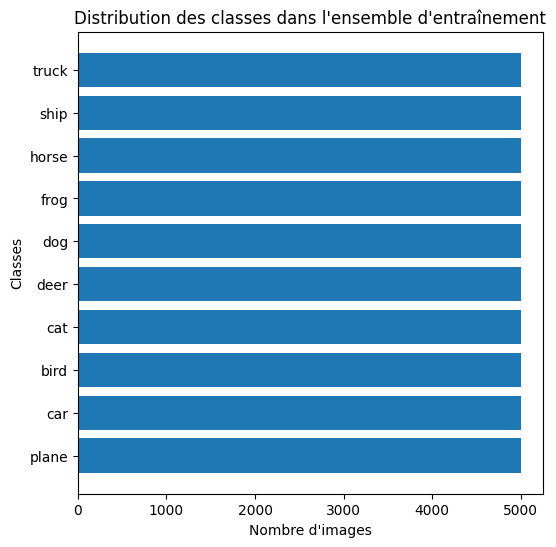

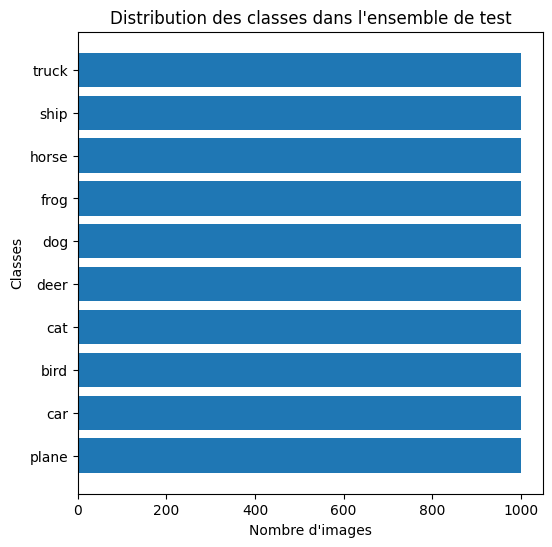

In [8]:
data_loader32.show_class_distribution('train')
data_loader32.show_class_distribution('test')

### Afficher les images et les labels d'un batch :

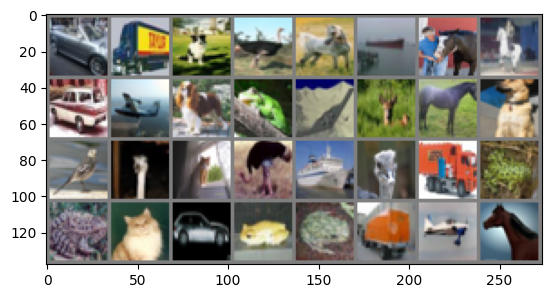

batch_size = 32 et dimension d'une image = torch.Size([3, 32, 32])
car	truck	dog	bird	horse	ship	horse	horse
car	plane	dog	frog	plane	deer	horse	dog
bird	bird	cat	bird	ship	bird	truck	frog
frog	cat	car	frog	frog	truck	plane	horse


In [9]:
data_loader32.show_one_random_batch()

# Création des modèles génériques

La méthode .size_debug(images.cuda()) est présente sur les deux modèles génériques. 

Elle permet de lancer une entrée à travers le réseau et d'afficher couche après couché la forme des données, jusqu'a la sortie du réseau. On l'a utilisé pour debuger nos modèles, pour vérifier les incomptabilités de shape ou de dimension. 

Elle est écrite de manière à s'adapter aux modifications éventuelles des classes des modèles des réseau de neurones : on a pas besoin de la modifier si jamais on modifie le modèle, elle va lire la methode .forward() et l'executée ligne par ligne sauf si il y a un commentaire ou va print le commentaire si il commence par '##'.


### Modèle Parkhi Générique

Cette classe représente le modèle du réseau de neurone du papier Parkhi. Par générique, on entend qu'elle permet de créer différentes instances du modèle avec des paramètres différents, par exemple elle permet de créer un réseau avec softmax en dernière couche et un réseau sans.

In [10]:
class P_Net(nn.Module):
  
  def __init__(self, 
               in_channels, 
               out_channels, 
               last_layer = 'No',
               do_dropout = 'No'):
    # in_channels = 3, pour rvb
    # out_channels = 10, c'est le nb de classes
    super().__init__()
  
        # do_dropout permet d'ajouter le drop_out de 0.5 spécifié dans le modèle Parkhi
    if do_dropout.lower() == 'no':
      self.dropout = nn.Identity()
    elif do_dropout.lower() == 'yes':
      self.dropout = nn.Dropout(0.5)
    else:
      print("argument 'do_dropout' invalide, choisir parmi 'yes' ou 'no'")
    # last_layer permet de choisir si la couche finale est softmax, log_softmax ou si il n'y en a pas
    if last_layer.lower() == 'no':
      self.last = nn.Identity()
    elif last_layer.lower() == 'softmax':
      self.last = F.softmax
    elif last_layer.lower() == 'log_softmax':
      self.last = F.log_softmax
    else:
      print("argument 'last_layer' invalide, choisir parmi 'softmax', 'log_softmax' ou 'no'")
    
    S = 32 # size
    # il s'agit du nombre de filtres de la premiere convolution
    # sur le papier Parkhi, S=64,
    # pour des raisons de RAM, on a choisit de diminuer S
    
    # les autres fonctions pour le modèle :

    self.conv11 = nn.Conv2d(in_channels, S, kernel_size=3, padding=1)
    self.bn11 = nn.BatchNorm2d(S)
    self.conv12 = nn.Conv2d(S, S, kernel_size=3, padding=1)
    self.bn12 = nn.BatchNorm2d(S)

    self.conv21 = nn.Conv2d(S, 2*S, kernel_size=3, padding=1)
    self.bn21 = nn.BatchNorm2d(2*S)
    self.conv22 = nn.Conv2d(2*S, 2*S, kernel_size=3, padding=1)
    self.bn22 = nn.BatchNorm2d(2*S)

    self.conv31 = nn.Conv2d(2*S, 2*2*S, kernel_size=3, padding=1)
    self.bn31 = nn.BatchNorm2d(2*2*S)
    self.conv32 = nn.Conv2d(2*2*S, 2*2*S, kernel_size=3, padding=1)
    self.bn32 = nn.BatchNorm2d(2*2*S)
    self.conv33 = nn.Conv2d(2*2*S, 2*2*S, kernel_size=3, padding=1)
    self.bn33 = nn.BatchNorm2d(2*2*S)

    self.conv41 = nn.Conv2d(2*2*S, 2*2*2*S, kernel_size=3, padding=1)
    self.bn41 = nn.BatchNorm2d(2*2*2*S)
    self.conv42 = nn.Conv2d(2*2*2*S, 2*2*2*S, kernel_size=3, padding=1)
    self.bn42 = nn.BatchNorm2d(2*2*2*S)
    self.conv43 = nn.Conv2d(2*2*2*S, 2*2*2*S, kernel_size=3, padding=1)
    self.bn43 = nn.BatchNorm2d(2*2*2*S)

    self.conv51 = nn.Conv2d(2*2*2*S, 2*2*2*S, kernel_size=3, padding=1)
    self.bn51 = nn.BatchNorm2d(2*2*2*S)
    self.conv52 = nn.Conv2d(2*2*2*S, 2*2*2*S, kernel_size=3, padding=1)
    self.bn52 = nn.BatchNorm2d(2*2*2*S)
    self.conv53 = nn.Conv2d(2*2*2*S, 2*2*2*S, kernel_size=3, padding=1)
    self.bn53 = nn.BatchNorm2d(2*2*2*S)

    self.fc6 = nn.Linear(in_features=2*2*2*S, out_features=4096)
    self.fc7 = nn.Linear(in_features=4096, out_features=4096)  
    self.fc8 = nn.Linear(in_features=4096, out_features=out_channels)
  
  def forward(self, x):
                  ## Stage 1
    ## conv11 :
    x = F.relu(self.bn11(self.conv11(x)))
    ## conv12 :
    x = F.relu(self.bn12(self.conv12(x)))
    ## maxpool :
    x = F.max_pool2d(x, kernel_size=2, stride=2)
                  ## Stage 2
    ## conv21 :
    x = F.relu(self.bn21(self.conv21(x)))
    ## conv22 :
    x = F.relu(self.bn22(self.conv22(x)))
    ## maxpool :
    x = F.max_pool2d(x, kernel_size=2, stride=2)
                  ## Stage 3
    ## conv31 :
    x = F.relu(self.bn31(self.conv31(x)))
    ## conv32 :
    x = F.relu(self.bn32(self.conv32(x)))
    ## conv33 :
    x = F.relu(self.bn33(self.conv33(x)))
    ## maxpool :
    x = F.max_pool2d(x, kernel_size=2, stride=2)
                  ## Stage 4
    ## conv41 :
    x = F.relu(self.bn41(self.conv41(x)))
    ## conv42 :
    x = F.relu(self.bn42(self.conv42(x)))
    ## conv43 :
    x = F.relu(self.bn43(self.conv43(x)))
    ## maxpool :
    x = F.max_pool2d(x, kernel_size=2, stride=2)
                  ## Stage 5
    ## conv51 :
    x = F.relu(self.bn51(self.conv51(x)))
    ## conv52 :
    x = F.relu(self.bn52(self.conv52(x)))
    ## conv53 :
    x = F.relu(self.bn53(self.conv53(x)))
    ## maxpool :
    x = F.max_pool2d(x, kernel_size=2, stride=2)
    ## flatten :
    x = torch.flatten(x, 1)
                  ## Stage 6
    ## fully connected 6 :
    x = F.relu(self.fc6(x))
                  ## Stage 7
    ## fully connected 7 :
    x = F.relu(self.fc7(x))
    ## dropout (si Yes) :
    x = self.dropout(x)
                  ## Stage 8
    ## fully connected 8 :
    x = F.relu(self.fc8(x))
    ## last layer :
    x = self.last(x)

    return x
  
  def size_debug(self, x):
        forward_source = inspect.getsource(self.forward)
        forward_lines = forward_source.split('\n')[1:-2]  # Skip def and return
        local_vars = locals()
        print("in :")
        print(x.shape)
        for line in forward_lines:
            if line.strip():
                if line.strip()[0] != '#':
                    exec(line.strip(), globals(), local_vars)
                    x = local_vars['x']
                    print(x.shape)
                elif line.strip()[0:2] == '##':
                    print(line.strip())
        print("out.")

### Modèle Simple générique

Cette classe représente notre modèle simple du réseau de neurone. Par générique, on entend qu'elle permet de créer différentes instances du modèle avec des paramètres différents, par exemple elle permet de créer un réseau avec softmax en dernière couche et un réseau sans. On peut aussi l'utilisé pour créer le modèle simple amélioré, qui possède un plus grand nombre de filtres de convolution.

In [11]:
class S_Net(nn.Module):
    
    def __init__(self, 
            in_channels, 
            out_channels,
            modele_ameliore = 'No',
            do_batchnorm = 'No',
            last_layer = 'No',
            do_dropout = 'No'):
        # in_channels = 3, pour rvb
        # out_channels = 10, c'est le nb de classes
        super().__init__()
        
        # on peut augmenter le nombre de filtre des convolutions avec le paramètre modele_ameliore
        if modele_ameliore.lower() == 'no':
            S1 = 6
            S2 = 16
        elif modele_ameliore.lower() == 'yes':
            S1 = 32
            S2 = 2*S1
        else:
            print("argument 'modele_ameliore' invalide, choisir parmi 'yes' ou 'no'")
        # do_batchnorm pour activer ou non le batchnorm après les convolutions
        if do_batchnorm.lower() == 'no':
            self.bn1 = nn.Identity()
            self.bn2 = nn.Identity()
        elif do_batchnorm.lower() == 'yes':
            self.bn1 = nn.BatchNorm2d(S1)
            self.bn2 = nn.BatchNorm2d(S2)
        else:
            print("argument 'do_batchnorm' invalide, choisir parmi 'yes' ou 'no'")
        # dropout pour activer ou non le dropout
        if do_dropout.lower() == 'no':
            self.dropout = nn.Identity()
        elif do_dropout.lower() == 'yes':
            self.dropout = nn.Dropout(0.5)
        else:
            print("argument 'do_dropout' invalide, choisir parmi 'yes' ou 'no'")
        # last_layer permet de choisir si la couche finale est softmax, log_softmax ou si il n'y en a pas
        if last_layer.lower() == 'no':
            self.last = nn.Identity()
        elif last_layer.lower() == 'softmax':
            self.last = F.softmax
        elif last_layer.lower() == 'log_softmax':
            self.last = F.log_softmax
        else:
            print("argument 'last_layer' invalide, choisir parmi 'softmax', 'log_softmax' ou 'no'")
            
        # les autres fonctions pour le modèle :
        self.conv1 = nn.Conv2d(in_channels, S1, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(S1, S2, 5)
        self.fc1 = nn.Linear(S2 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, out_channels)
            
    def forward(self, x):
        ## conv1 puis bn (si Yes) puis pool :
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        ## conv2 puis bn (si Yes) puis pool :
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        ## flatten :
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        ## dropout (si Yes) :
        x = self.dropout(x)
        ## fully connected 1 :
        x = F.relu(self.fc1(x))
        ## fully connected 2 :
        x = F.relu(self.fc2(x))
        ## fully connected 3 :
        x = self.fc3(x)
        ## last layer :
        x = self.last(x)
        return x
    
    def size_debug(self, x):
        forward_source = inspect.getsource(self.forward)
        forward_lines = forward_source.split('\n')[1:-2]  # Skip def and return
        local_vars = locals()
        print("in :")
        print(x.shape)
        for line in forward_lines:
            if line.strip():
                if line.strip()[0] != '#':
                    exec(line.strip(), globals(), local_vars)
                    x = local_vars['x']
                    print(x.shape)
                elif line.strip()[0:2] == '##':
                    print(line.strip())
        print("out.")

# Les Algorithmes d'optimisation et les Critères

On utilisera dans nos expériences deux algorithmes d'optimisation :
1) la Descente de Gradient Stochastique (learning rate = 0.001 et momentum coefficient of 0.9, comme sur le papier Parkhi et al)
2) l'Adaptive Moment Estimation ADAM (learning rate = 0.001)

Et on se penchera sur deux critères d'optimisation :
1) la CrossEntropy
2) la Négative LogLikelyhood

In [12]:
import torch.optim as optim

def optimizer_SDG(parametres_initaux, lr):
    return optim.SGD(parametres_initaux, lr=lr, momentum=0.9)
def optimizer_ADAM(parametres_initaux, lr):
    return optim.Adam(parametres_initaux , lr=lr)

criterion_CE = nn.CrossEntropyLoss()
criterion_NLL = nn.NLLLoss()

# Le Modèle PARKHI

On va ici entraîner et regarder les précisions du modèle, en fonction de différents hyperparamètres.

### **Influence du batch_size** :

#### *Création des modèles* :

On utilise les classes des modèles génériques. Ici par contre les deux modèles sont identitques, mais ils s'entraineront sur deux data_loader différents, découpés chacun avec un différent batch_size.

In [13]:
data_loader16 = DataLoader(16, cifar=10)
parkhi_batchsize_net1 = P_Net(
    3,
    10,
)
parkhi_batchsize_net1 = parkhi_batchsize_net1.cuda()

data_loader256 = DataLoader(256, cifar=10)
parkhi_batchsize_net2 = P_Net(
    3,
    10,
)
parkhi_batchsize_net2 = parkhi_batchsize_net2.cuda()

print("\nVisualisation des shapes des datas, net1 s’entraînant avec batch_size=16 :")
images, labels = data_loader16.get_random_train_batch()
parkhi_batchsize_net1.size_debug(images.cuda())

print("\nVisualisation des shapes des datas, net2 s’entraînant avec batch_size=256 :")
images, labels = data_loader256.get_random_train_batch()
parkhi_batchsize_net2.size_debug(images.cuda())


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified

Visualisation des shapes des datas, net1 s’entraînant avec batch_size=16 :
in :
torch.Size([16, 3, 32, 32])
## Stage 1
## conv11 :
torch.Size([16, 32, 32, 32])
## conv12 :
torch.Size([16, 32, 32, 32])
## maxpool :
torch.Size([16, 32, 16, 16])
## Stage 2
## conv21 :
torch.Size([16, 64, 16, 16])
## conv22 :
torch.Size([16, 64, 16, 16])
## maxpool :
torch.Size([16, 64, 8, 8])
## Stage 3
## conv31 :
torch.Size([16, 128, 8, 8])
## conv32 :
torch.Size([16, 128, 8, 8])
## conv33 :
torch.Size([16, 128, 8, 8])
## maxpool :
torch.Size([16, 128, 4, 4])
## Stage 4
## conv41 :
torch.Size([16, 256, 4, 4])
## conv42 :
torch.Size([16, 256, 4, 4])
## conv43 :
torch.Size([16, 256, 4, 4])
## maxpool :
torch.Size([16, 256, 2, 2])
## Stage 5
## conv51 :
torch.Size([16, 256, 2, 2])
## conv52 :
torch.Size([16, 256, 2, 2])
## conv53 :
torch.Size([16, 256, 2, 

#### *Entraînements et visualisation des performances, comparaison du temps de computation :*

###### net 1 : batch_size=16

EPOCH #1
[1, 8992] loss: 2.249
[1, 18000] loss: 2.199
[1, 27008] loss: 2.138
[1, 36016] loss: 2.102
[1, 45024] loss: 2.077
Accuracy of the network on the 50000 train images: 17.432 %
Accuracy of the network on the 10000 test images: 17.37 %
EPOCH #2
[2, 8992] loss: 2.042
[2, 18000] loss: 2.036
[2, 27008] loss: 2.042
[2, 36016] loss: 2.031
[2, 45024] loss: 2.017
Accuracy of the network on the 50000 train images: 18.478 %
Accuracy of the network on the 10000 test images: 18.15 %
EPOCH #3
[3, 8992] loss: 1.996
[3, 18000] loss: 2.008
[3, 27008] loss: 1.976
[3, 36016] loss: 1.979
[3, 45024] loss: 1.993
Accuracy of the network on the 50000 train images: 18.864 %
Accuracy of the network on the 10000 test images: 18.17 %
EPOCH #4
[4, 8992] loss: 1.963
[4, 18000] loss: 1.965
[4, 27008] loss: 1.962
[4, 36016] loss: 1.975
[4, 45024] loss: 1.955
Accuracy of the network on the 50000 train images: 19.136 %
Accuracy of the network on the 10000 test images: 18.3 %
EPOCH #5
[5, 8992] loss: 1.945
[5, 18

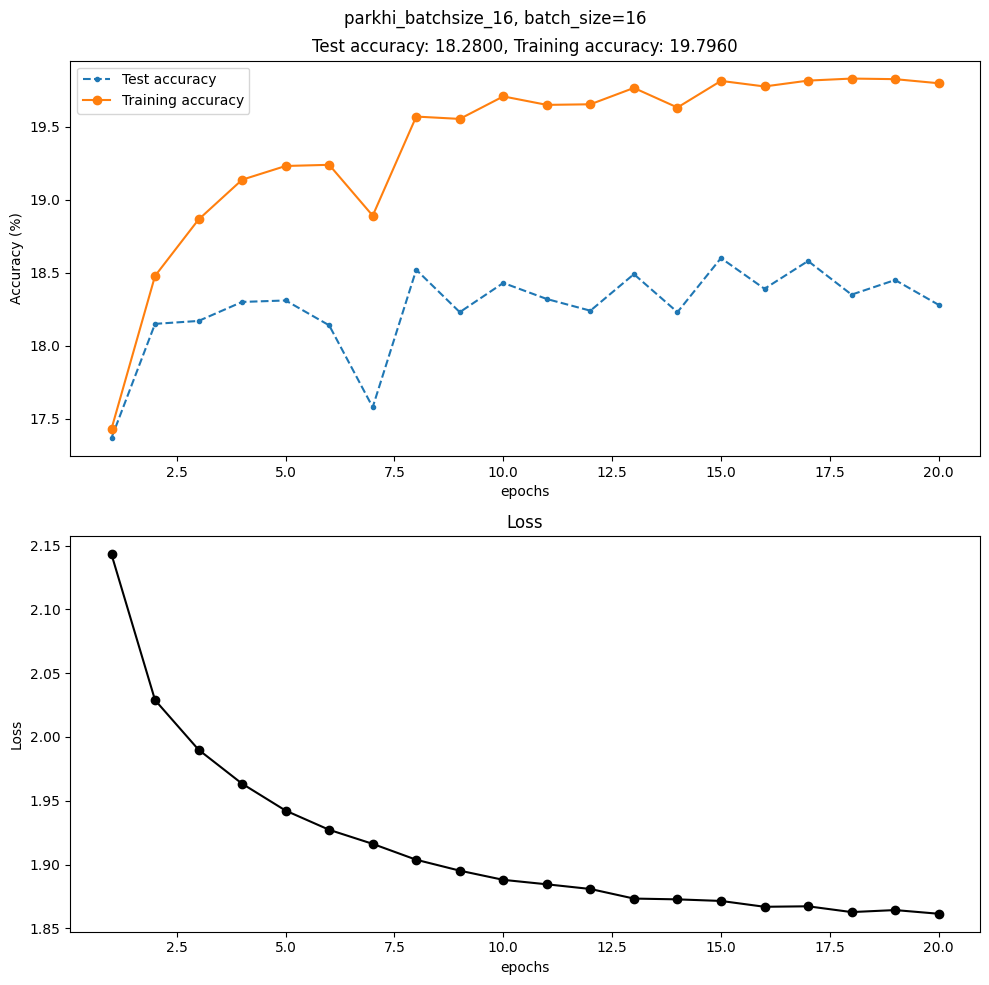

In [14]:
parkhi_batchsize_net1_train = TrainEtPrecision(
    data_loader16, 
    parkhi_batchsize_net1, 
    criterion_CE, 
    optimizer_SDG(parkhi_batchsize_net1.parameters(), lr=0.001), 
    20, 
    "parkhi_batchsize_16"
    )

###### net 2 : batch_size=256

EPOCH #1
[1, 8960] loss: 2.347
[1, 18176] loss: 2.273
[1, 27392] loss: 2.120
[1, 36608] loss: 2.014
[1, 45824] loss: 1.875
Accuracy of the network on the 50000 train images: 39.684 %
Accuracy of the network on the 10000 test images: 39.03 %
EPOCH #2
[2, 8960] loss: 1.724
[2, 18176] loss: 1.667
[2, 27392] loss: 1.547
[2, 36608] loss: 1.476
[2, 45824] loss: 1.441
Accuracy of the network on the 50000 train images: 54.562 %
Accuracy of the network on the 10000 test images: 51.14 %
EPOCH #3
[3, 8960] loss: 1.300
[3, 18176] loss: 1.282
[3, 27392] loss: 1.264
[3, 36608] loss: 1.239
[3, 45824] loss: 1.223
Accuracy of the network on the 50000 train images: 63.596 %
Accuracy of the network on the 10000 test images: 58.48 %
EPOCH #4
[4, 8960] loss: 1.096
[4, 18176] loss: 1.064
[4, 27392] loss: 0.954
[4, 36608] loss: 0.889
[4, 45824] loss: 0.877
Accuracy of the network on the 50000 train images: 74.884 %
Accuracy of the network on the 10000 test images: 67.14 %
EPOCH #5
[5, 8960] loss: 0.730
[5, 1

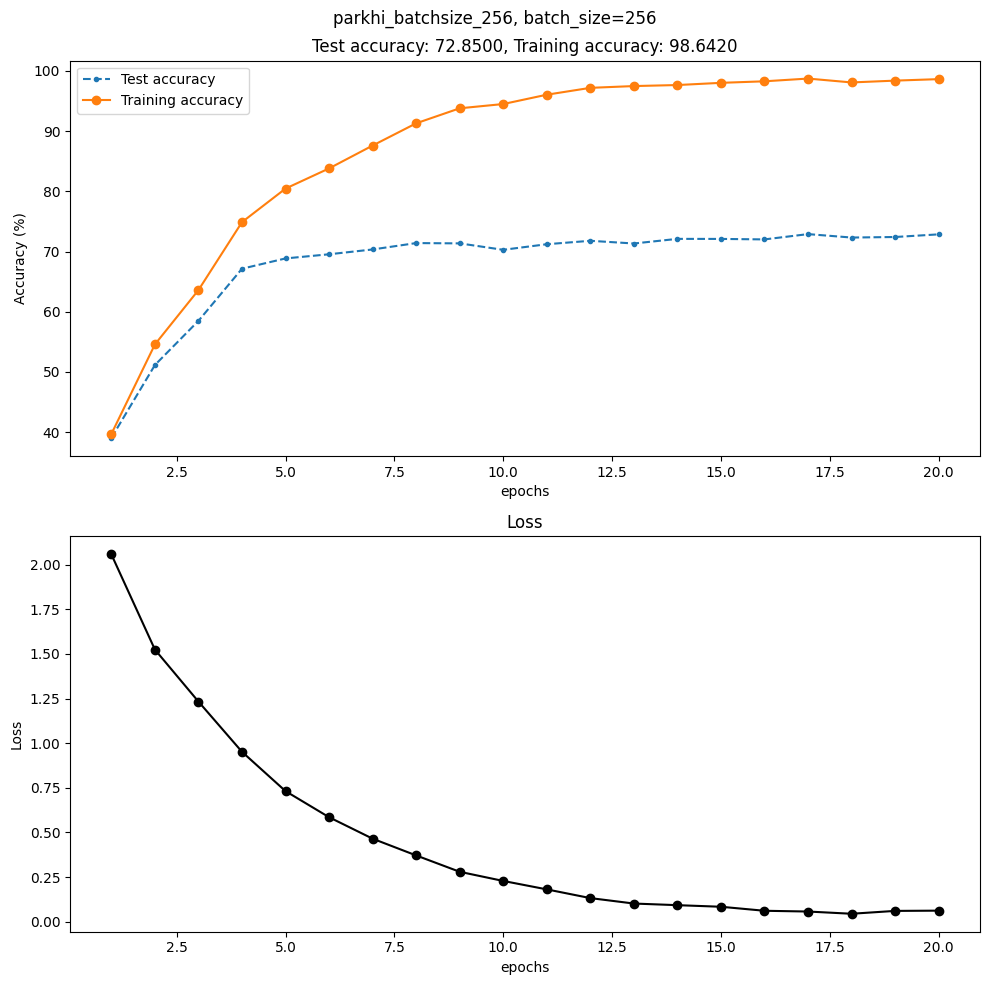

In [15]:
parkhi_batchsize_net2_train = TrainEtPrecision(
    data_loader256, 
    parkhi_batchsize_net2, 
    criterion_CE, 
    optimizer_SDG(parkhi_batchsize_net2.parameters(), lr=0.001), 
    20, 
    "parkhi_batchsize_256"
    )

### **Influence du soft_max** :

#### *Création des modèles* :

Ici on a un modèle sans soft_max et un modèle avec softmax

In [16]:
parkhi_softmax_net1 = P_Net(
    3,
    10,
    last_layer='no'
)
parkhi_softmax_net1 = parkhi_softmax_net1.cuda()

parkhi_softmax_net2 = P_Net(
    3,
    10,
    last_layer='softmax'
)
parkhi_softmax_net2 = parkhi_softmax_net2.cuda()

#### *Entraînements et visualisation des performances, comparaison du temps de computation :*

###### net 1 : sans softmax

EPOCH #1
[1, 8992] loss: 2.237
[1, 18016] loss: 2.133
[1, 27040] loss: 2.107
[1, 36064] loss: 2.060
[1, 45088] loss: 2.040
Accuracy of the network on the 50000 train images: 23.964 %
Accuracy of the network on the 10000 test images: 23.73 %
EPOCH #2
[2, 8992] loss: 2.005
[2, 18016] loss: 1.988
[2, 27040] loss: 1.977
[2, 36064] loss: 1.910
[2, 45088] loss: 1.805
Accuracy of the network on the 50000 train images: 36.896 %
Accuracy of the network on the 10000 test images: 35.3 %
EPOCH #3
[3, 8992] loss: 1.701
[3, 18016] loss: 1.712
[3, 27040] loss: 1.698
[3, 36064] loss: 1.665
[3, 45088] loss: 1.581
Accuracy of the network on the 50000 train images: 45.156 %
Accuracy of the network on the 10000 test images: 42.08 %
EPOCH #4
[4, 8992] loss: 1.474
[4, 18016] loss: 1.488
[4, 27040] loss: 1.463
[4, 36064] loss: 1.479
[4, 45088] loss: 1.463
Accuracy of the network on the 50000 train images: 48.676 %
Accuracy of the network on the 10000 test images: 44.06 %
EPOCH #5
[5, 8992] loss: 1.378
[5, 18

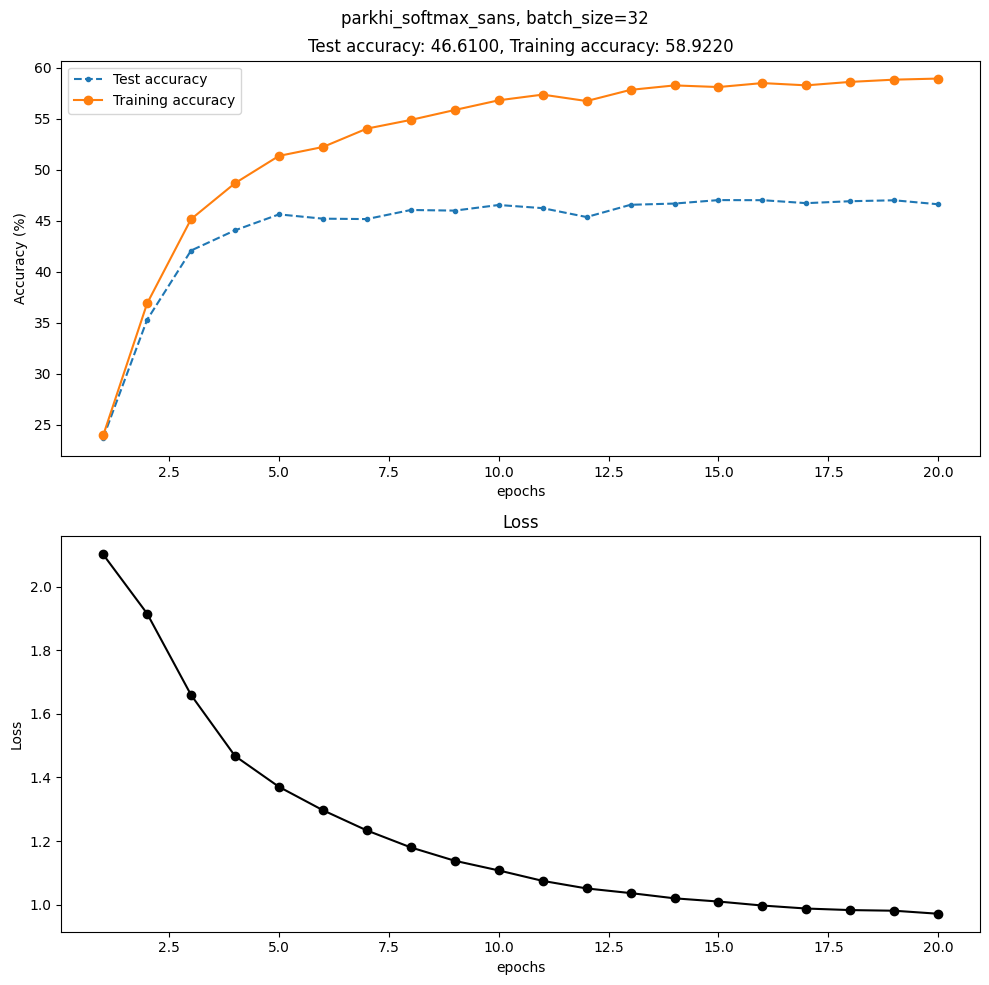

In [17]:
parkhi_softmax_net1_train = TrainEtPrecision(
    data_loader32, 
    parkhi_softmax_net1, 
    criterion_CE,
    optimizer_SDG(parkhi_softmax_net1.parameters(), lr=0.001), 
    20, 
    "parkhi_softmax_sans"
    )

###### net 2 : avec softmax

EPOCH #1


C:\Users\ferdi\AppData\Local\Temp\ipykernel_36712\1491462521.py:127: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.last(x)


[1, 8992] loss: 2.301
[1, 18016] loss: 2.249
[1, 27040] loss: 2.191
[1, 36064] loss: 2.136
[1, 45088] loss: 2.101
Accuracy of the network on the 50000 train images: 38.558 %
Accuracy of the network on the 10000 test images: 38.62 %
EPOCH #2
[2, 8992] loss: 2.060
[2, 18016] loss: 2.021
[2, 27040] loss: 1.991
[2, 36064] loss: 1.985
[2, 45088] loss: 1.973
Accuracy of the network on the 50000 train images: 52.922 %
Accuracy of the network on the 10000 test images: 50.99 %
EPOCH #3
[3, 8992] loss: 1.943
[3, 18016] loss: 1.941
[3, 27040] loss: 1.933
[3, 36064] loss: 1.928
[3, 45088] loss: 1.924
Accuracy of the network on the 50000 train images: 56.28 %
Accuracy of the network on the 10000 test images: 55.0 %
EPOCH #4
[4, 8992] loss: 1.894
[4, 18016] loss: 1.905
[4, 27040] loss: 1.901
[4, 36064] loss: 1.901
[4, 45088] loss: 1.882
Accuracy of the network on the 50000 train images: 58.954 %
Accuracy of the network on the 10000 test images: 56.46 %
EPOCH #5
[5, 8992] loss: 1.873
[5, 18016] loss:

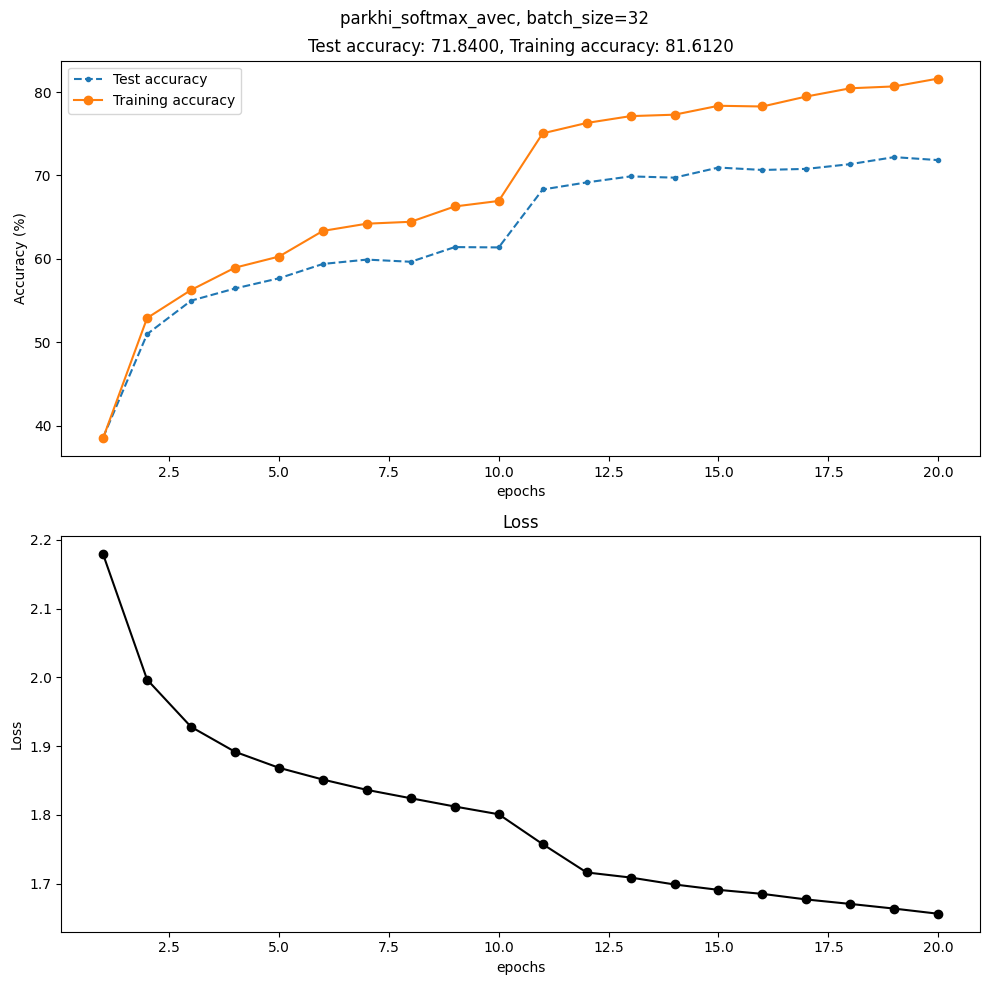

In [18]:
parkhi_softmax_net2_train = TrainEtPrecision(
    data_loader32, 
    parkhi_softmax_net2, 
    criterion_CE,
    optimizer_SDG(parkhi_softmax_net2.parameters(), lr=0.001), 
    20, 
    "parkhi_softmax_avec"
    )

### **Influence du dropout** :

#### *Création des modèles* :

Ici on a un modèle sans dropout et un modèle avec dropout de 0.5, situé entre la couche dense du layer 8 et la couche dense du layer 9 comme préciser dans le papier Parkhi et al.

In [19]:
parkhi_dropout_net1 = P_Net(
    3,
    10,
    do_dropout='no',
)
parkhi_dropout_net1 = parkhi_dropout_net1.cuda()

parkhi_dropout_net2 = P_Net(
    3,
    10,
    do_dropout='yes'
)
parkhi_dropout_net2 = parkhi_dropout_net2.cuda()

#### *Entraînements et visualisation des performances, comparaison du temps de computation :*

###### net1 : sans dropout

EPOCH #1
[1, 8992] loss: 2.173
[1, 18016] loss: 2.050
[1, 27040] loss: 1.954
[1, 36064] loss: 1.886
[1, 45088] loss: 1.865
Accuracy of the network on the 50000 train images: 38.244 %
Accuracy of the network on the 10000 test images: 37.3 %
EPOCH #2
[2, 8992] loss: 1.716
[2, 18016] loss: 1.687
[2, 27040] loss: 1.688
[2, 36064] loss: 1.658
[2, 45088] loss: 1.632
Accuracy of the network on the 50000 train images: 41.72 %
Accuracy of the network on the 10000 test images: 40.68 %
EPOCH #3
[3, 8992] loss: 1.576
[3, 18016] loss: 1.543
[3, 27040] loss: 1.536
[3, 36064] loss: 1.491
[3, 45088] loss: 1.395
Accuracy of the network on the 50000 train images: 57.03 %
Accuracy of the network on the 10000 test images: 54.87 %
EPOCH #4
[4, 8992] loss: 1.264
[4, 18016] loss: 1.192
[4, 27040] loss: 1.169
[4, 36064] loss: 1.131
[4, 45088] loss: 1.131
Accuracy of the network on the 50000 train images: 64.308 %
Accuracy of the network on the 10000 test images: 60.36 %
EPOCH #5
[5, 8992] loss: 0.992
[5, 1801

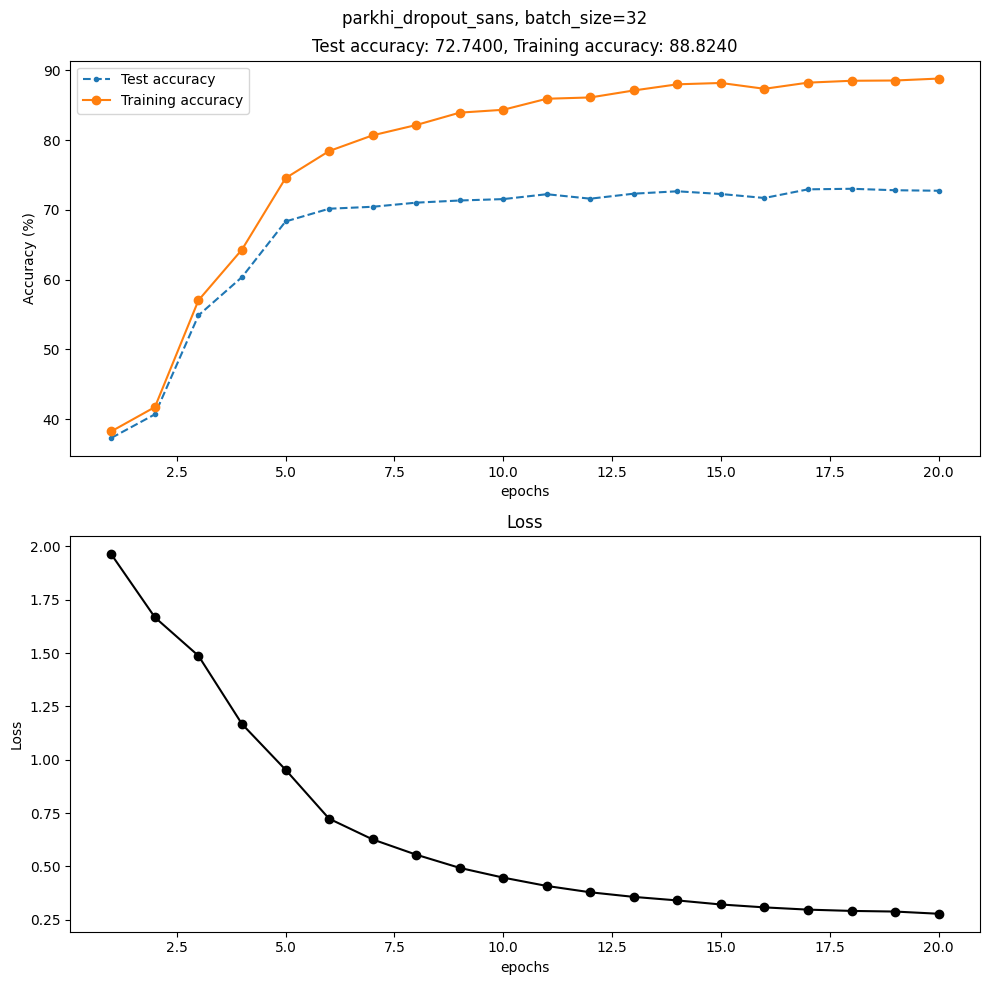

In [20]:
parkhi_dropout_net1_train = TrainEtPrecision(
    data_loader32, 
    parkhi_dropout_net1, 
    criterion_CE,
    optimizer_SDG(parkhi_dropout_net1.parameters(), lr=0.001), 
    20, 
    "parkhi_dropout_sans"
    )

###### net2 : avec dropout

EPOCH #1
[1, 8992] loss: 2.242
[1, 18016] loss: 2.014
[1, 27040] loss: 1.809
[1, 36064] loss: 1.486
[1, 45088] loss: 1.255
Accuracy of the network on the 50000 train images: 60.574 %
Accuracy of the network on the 10000 test images: 58.27 %
EPOCH #2
[2, 8992] loss: 1.069
[2, 18016] loss: 1.014
[2, 27040] loss: 0.938
[2, 36064] loss: 0.901
[2, 45088] loss: 0.856
Accuracy of the network on the 50000 train images: 74.514 %
Accuracy of the network on the 10000 test images: 71.08 %
EPOCH #3
[3, 8992] loss: 0.725
[3, 18016] loss: 0.727
[3, 27040] loss: 0.708
[3, 36064] loss: 0.682
[3, 45088] loss: 0.670
Accuracy of the network on the 50000 train images: 81.12 %
Accuracy of the network on the 10000 test images: 75.32 %
EPOCH #4
[4, 8992] loss: 0.561
[4, 18016] loss: 0.549
[4, 27040] loss: 0.568
[4, 36064] loss: 0.571
[4, 45088] loss: 0.565
Accuracy of the network on the 50000 train images: 84.114 %
Accuracy of the network on the 10000 test images: 76.68 %
EPOCH #5
[5, 8992] loss: 0.439
[5, 18

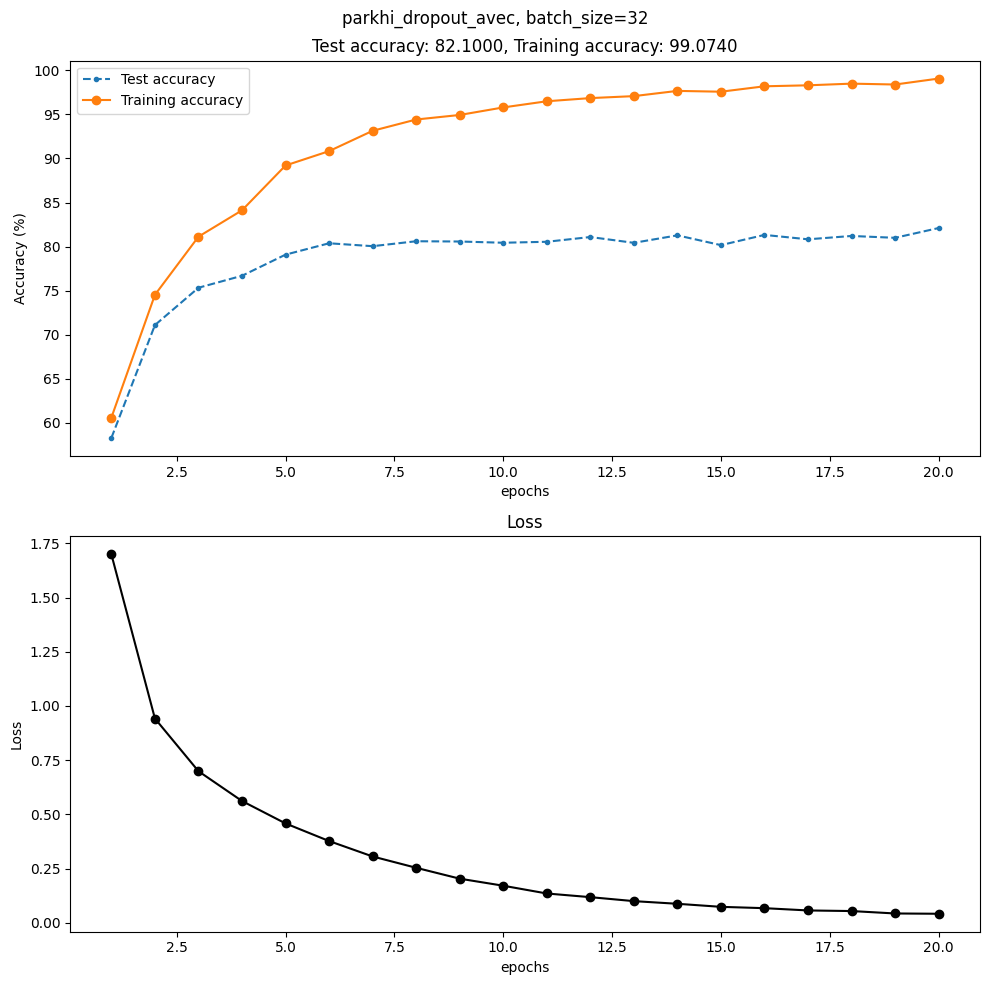

In [21]:
parkhi_dropout_net2_train = TrainEtPrecision(
    data_loader32, 
    parkhi_dropout_net2, 
    criterion_CE,
    optimizer_SDG(parkhi_dropout_net2.parameters(), lr=0.001), 
    20, 
    "parkhi_dropout_avec"
    )

### **Le modèle complet :**


in :
torch.Size([32, 3, 32, 32])
## Stage 1
## conv11 :
torch.Size([32, 32, 32, 32])
## conv12 :
torch.Size([32, 32, 32, 32])
## maxpool :
torch.Size([32, 32, 16, 16])
## Stage 2
## conv21 :
torch.Size([32, 64, 16, 16])
## conv22 :
torch.Size([32, 64, 16, 16])
## maxpool :
torch.Size([32, 64, 8, 8])
## Stage 3
## conv31 :
torch.Size([32, 128, 8, 8])
## conv32 :
torch.Size([32, 128, 8, 8])
## conv33 :
torch.Size([32, 128, 8, 8])
## maxpool :
torch.Size([32, 128, 4, 4])
## Stage 4
## conv41 :
torch.Size([32, 256, 4, 4])
## conv42 :
torch.Size([32, 256, 4, 4])
## conv43 :
torch.Size([32, 256, 4, 4])
## maxpool :
torch.Size([32, 256, 2, 2])
## Stage 5
## conv51 :
torch.Size([32, 256, 2, 2])
## conv52 :
torch.Size([32, 256, 2, 2])
## conv53 :
torch.Size([32, 256, 2, 2])
## maxpool :
torch.Size([32, 256, 1, 1])
## flatten :
torch.Size([32, 256])
## Stage 6
## fully connected 6 :
torch.Size([32, 4096])
## Stage 7
## fully connected 7 :
torch.Size([32, 4096])
## dropout (si Yes) :
torch.Size([

<string>:1: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\ferdi\AppData\Local\Temp\ipykernel_36712\1491462521.py:127: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.last(x)


[1, 8992] loss: 2.015
[1, 18016] loss: 1.541
[1, 27040] loss: 1.351
[1, 36064] loss: 1.235
[1, 45088] loss: 1.129
Accuracy of the network on the 50000 train images: 62.24 %
Accuracy of the network on the 10000 test images: 59.62 %
EPOCH #2
[2, 8992] loss: 0.978
[2, 18016] loss: 0.941
[2, 27040] loss: 0.887
[2, 36064] loss: 0.859
[2, 45088] loss: 0.847
Accuracy of the network on the 50000 train images: 75.236 %
Accuracy of the network on the 10000 test images: 71.58 %
EPOCH #3
[3, 8992] loss: 0.715
[3, 18016] loss: 0.704
[3, 27040] loss: 0.708
[3, 36064] loss: 0.682
[3, 45088] loss: 0.662
Accuracy of the network on the 50000 train images: 81.672 %
Accuracy of the network on the 10000 test images: 74.85 %
EPOCH #4
[4, 8992] loss: 0.540
[4, 18016] loss: 0.550
[4, 27040] loss: 0.580
[4, 36064] loss: 0.538
[4, 45088] loss: 0.564
Accuracy of the network on the 50000 train images: 85.654 %
Accuracy of the network on the 10000 test images: 77.12 %
EPOCH #5
[5, 8992] loss: 0.418
[5, 18016] loss

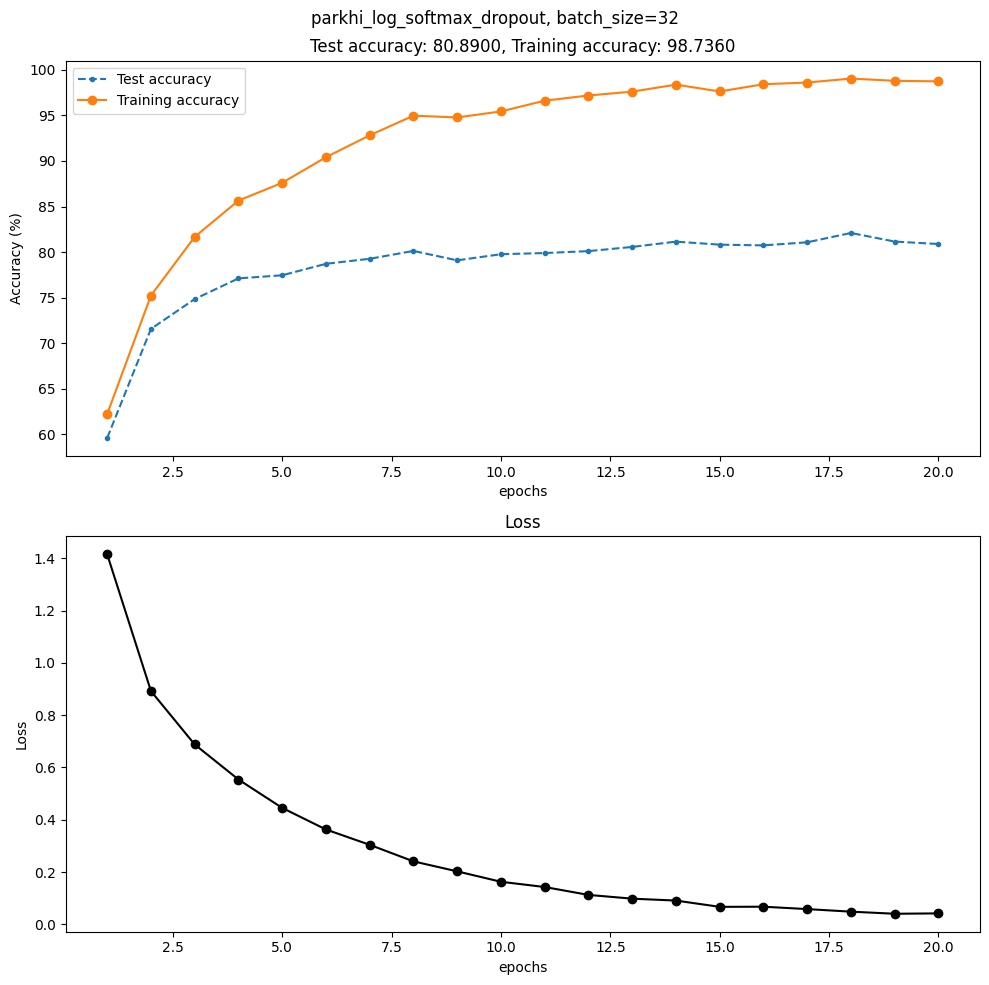

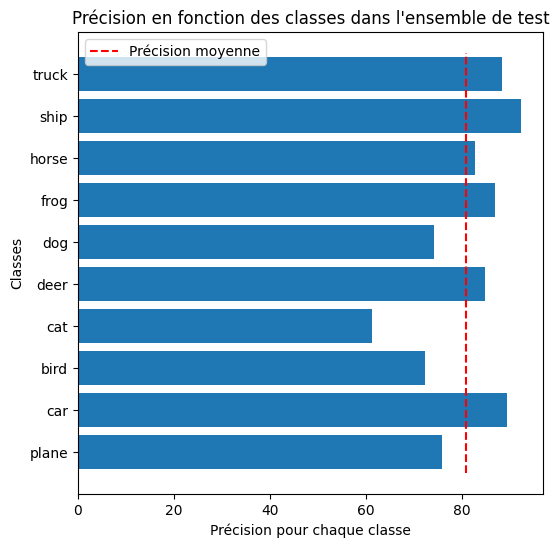

In [22]:
parkhi_net = P_Net(
    3, 
    10, 
    last_layer='log_softmax', 
    do_dropout='yes'
    )
parkhi_net = parkhi_net.cuda()

images, labels = data_loader32.get_random_train_batch()
parkhi_net.size_debug(images.cuda())

parkhi_net_train = TrainEtPrecision(
    data_loader32,
    parkhi_net,
    criterion_CE, 
    optimizer_SDG(parkhi_net.parameters(), lr=0.001),
    20,
    "parkhi_log_softmax_dropout"
    )

parkhi_net_train.plot_accuracy_for_each_classes()

# Le Modèle Simplifié

On va maintenant travailler sur un modèle simplifié, le modèle simple. Celui contient moins de couches et est beaucoup moins complexe, et permettra de tester les couches utilisées dans le modèle Parkhi en les intégrant dessus.

On l'utilise aussi car il possède beaucoup moins de paramètres, et donc son temps d’entraînement est beaucoup plus court et cela nous permet donc de gagner beaucoup de temps par la suite.

### **Influence du batchnorm** :

#### *Création des modèles* :

In [23]:
simple_batchnorm_net1 = S_Net(
    3,
    10, 
    do_batchnorm='No'
    )
simple_batchnorm_net1 = simple_batchnorm_net1.cuda()

simple_batchnorm_net2 = S_Net(
    3,
    10, 
    do_batchnorm='Yes'
    )
simple_batchnorm_net2 = simple_batchnorm_net2.cuda()

#### *Entraînements et visualisation des performances, comparaison du temps de computation :*

###### net1 : sans batchnorm

EPOCH #1
[1, 8992] loss: 2.310
[1, 18016] loss: 2.306
[1, 27040] loss: 2.299
[1, 36064] loss: 2.277
[1, 45088] loss: 2.216
Accuracy of the network on the 50000 train images: 22.712 %
Accuracy of the network on the 10000 test images: 23.43 %
EPOCH #2
[2, 8992] loss: 2.126
[2, 18016] loss: 2.071
[2, 27040] loss: 2.036
[2, 36064] loss: 2.003
[2, 45088] loss: 1.929
Accuracy of the network on the 50000 train images: 30.584 %
Accuracy of the network on the 10000 test images: 31.68 %
EPOCH #3
[3, 8992] loss: 1.848
[3, 18016] loss: 1.809
[3, 27040] loss: 1.756
[3, 36064] loss: 1.718
[3, 45088] loss: 1.686
Accuracy of the network on the 50000 train images: 39.728 %
Accuracy of the network on the 10000 test images: 39.46 %
EPOCH #4
[4, 8992] loss: 1.631
[4, 18016] loss: 1.600
[4, 27040] loss: 1.577
[4, 36064] loss: 1.550
[4, 45088] loss: 1.525
Accuracy of the network on the 50000 train images: 45.028 %
Accuracy of the network on the 10000 test images: 45.35 %
EPOCH #5
[5, 8992] loss: 1.512
[5, 1

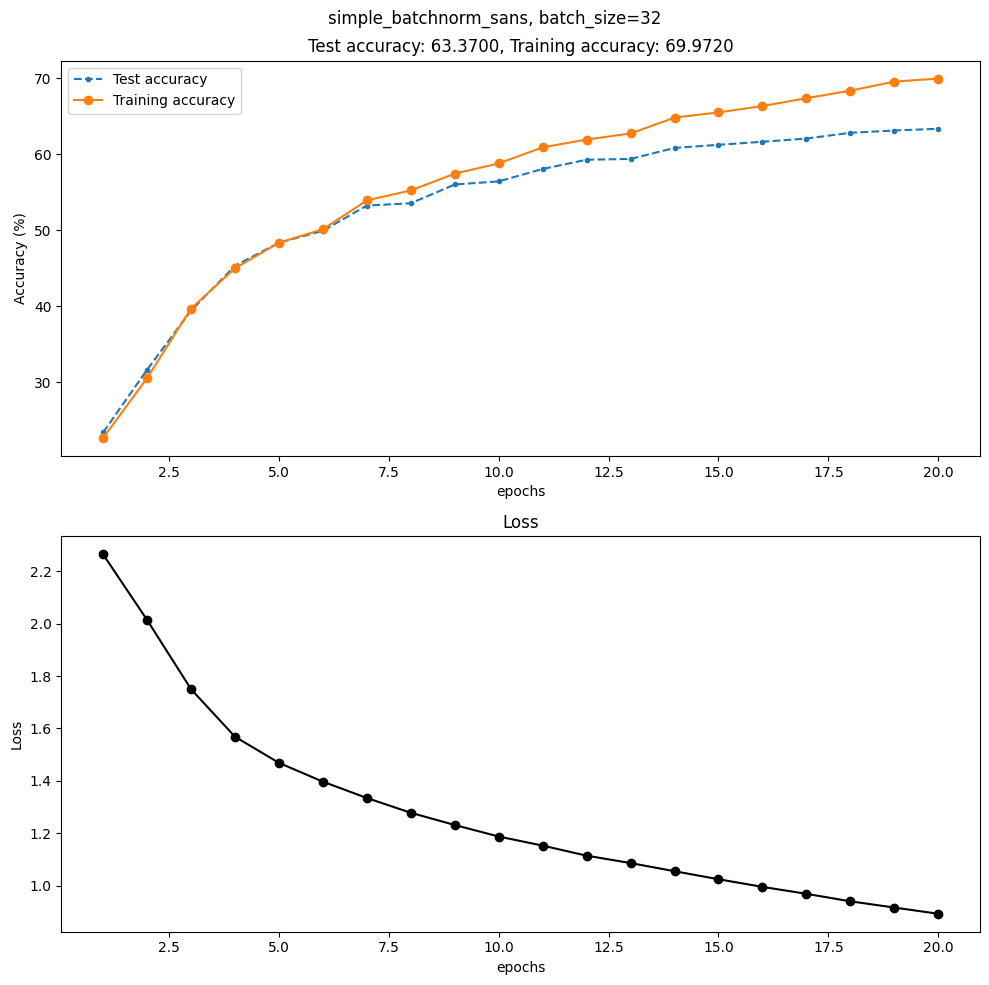

In [24]:
simple_batchnorm_net1_train = TrainEtPrecision(
    data_loader32, 
    simple_batchnorm_net1, 
    criterion_CE,
    optimizer_SDG(simple_batchnorm_net1.parameters(), lr=0.001), 
    20, 
    "simple_batchnorm_sans"
    )

###### net2 : avec batchnorm

EPOCH #1
[1, 8992] loss: 2.226
[1, 18016] loss: 1.960
[1, 27040] loss: 1.760
[1, 36064] loss: 1.612
[1, 45088] loss: 1.542
Accuracy of the network on the 50000 train images: 45.976 %
Accuracy of the network on the 10000 test images: 46.03 %
EPOCH #2
[2, 8992] loss: 1.441
[2, 18016] loss: 1.431
[2, 27040] loss: 1.402
[2, 36064] loss: 1.396
[2, 45088] loss: 1.367
Accuracy of the network on the 50000 train images: 52.588 %
Accuracy of the network on the 10000 test images: 52.94 %
EPOCH #3
[3, 8992] loss: 1.308
[3, 18016] loss: 1.311
[3, 27040] loss: 1.274
[3, 36064] loss: 1.264
[3, 45088] loss: 1.239
Accuracy of the network on the 50000 train images: 57.622 %
Accuracy of the network on the 10000 test images: 56.53 %
EPOCH #4
[4, 8992] loss: 1.211
[4, 18016] loss: 1.214
[4, 27040] loss: 1.186
[4, 36064] loss: 1.193
[4, 45088] loss: 1.170
Accuracy of the network on the 50000 train images: 58.81 %
Accuracy of the network on the 10000 test images: 57.46 %
EPOCH #5
[5, 8992] loss: 1.148
[5, 18

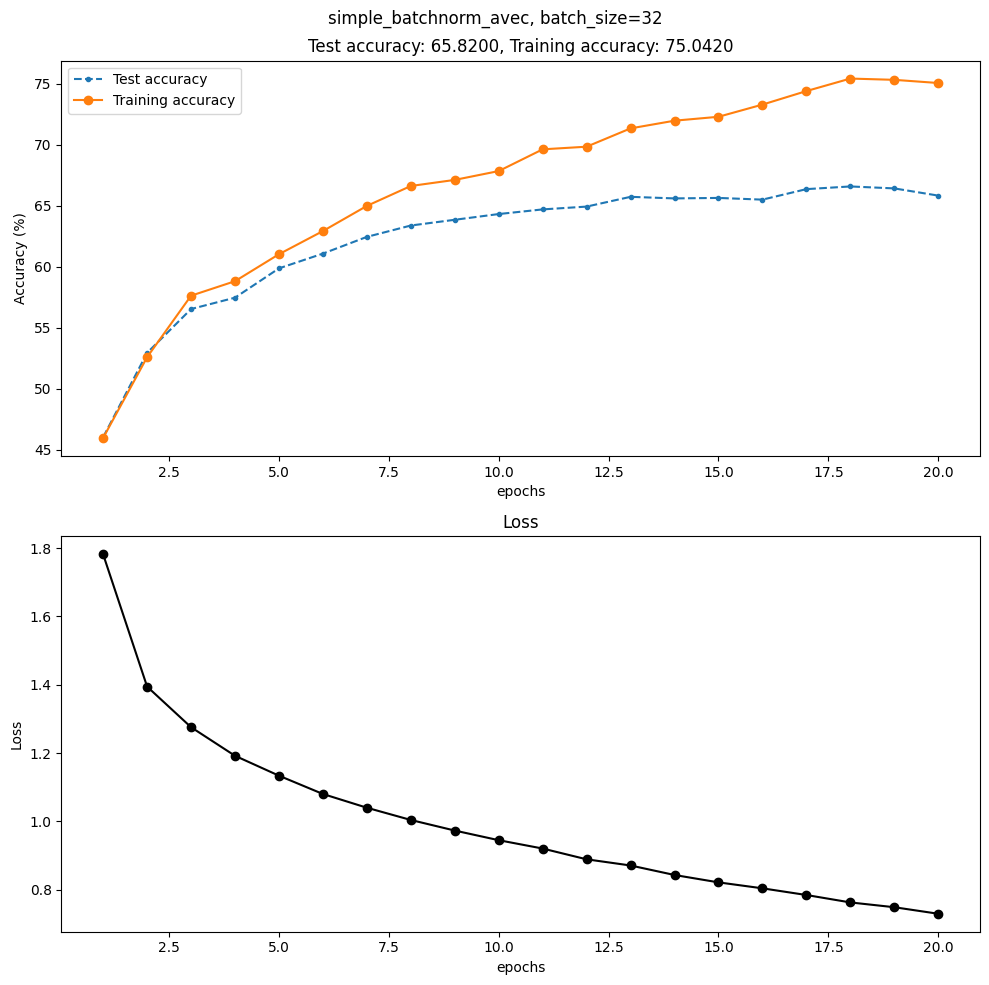

In [25]:
simple_batchnorm_net2_train = TrainEtPrecision(
    data_loader32, 
    simple_batchnorm_net2, 
    criterion_CE,
    optimizer_SDG(simple_batchnorm_net2.parameters(), lr=0.001), 
    20, 
    "simple_batchnorm_avec"
    )

### **Influence du softmax** :

#### *Création des modèles* :

In [26]:
simple_softmax_net1 = S_Net(
    3,
    10, 
    last_layer='No'
    )
simple_softmax_net1 = simple_softmax_net1.cuda()

simple_softmax_net2 = S_Net(
    3,
    10, 
    last_layer='Softmax'
    )
simple_softmax_net2 = simple_softmax_net2.cuda()

#### *Entraînements et visualisation des performances, comparaison du temps de computation :*

###### net1 : sans softmax

EPOCH #1
[1, 8992] loss: 2.309
[1, 18016] loss: 2.305
[1, 27040] loss: 2.294
[1, 36064] loss: 2.230
[1, 45088] loss: 2.077
Accuracy of the network on the 50000 train images: 29.05 %
Accuracy of the network on the 10000 test images: 29.99 %
EPOCH #2
[2, 8992] loss: 1.931
[2, 18016] loss: 1.873
[2, 27040] loss: 1.820
[2, 36064] loss: 1.767
[2, 45088] loss: 1.722
Accuracy of the network on the 50000 train images: 39.314 %
Accuracy of the network on the 10000 test images: 40.04 %
EPOCH #3
[3, 8992] loss: 1.642
[3, 18016] loss: 1.621
[3, 27040] loss: 1.613
[3, 36064] loss: 1.559
[3, 45088] loss: 1.535
Accuracy of the network on the 50000 train images: 45.758 %
Accuracy of the network on the 10000 test images: 45.45 %
EPOCH #4
[4, 8992] loss: 1.518
[4, 18016] loss: 1.473
[4, 27040] loss: 1.481
[4, 36064] loss: 1.459
[4, 45088] loss: 1.444
Accuracy of the network on the 50000 train images: 47.226 %
Accuracy of the network on the 10000 test images: 46.5 %
EPOCH #5
[5, 8992] loss: 1.422
[5, 180

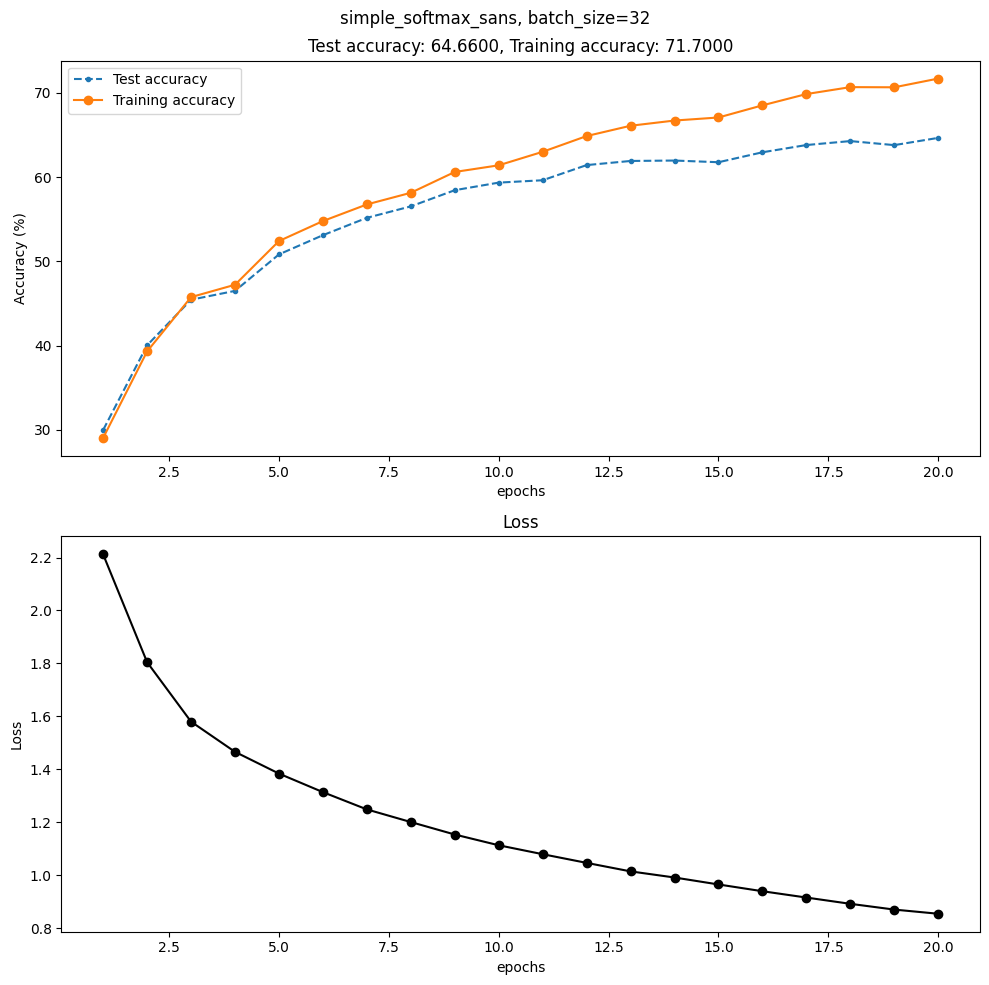

In [27]:
simple_softmax_net1_train = TrainEtPrecision(
    data_loader32,
    simple_softmax_net1, 
    criterion_CE,
    optimizer_SDG(simple_softmax_net1.parameters(), lr=0.001), 
    20, 
    "simple_softmax_sans"
    )

###### net2 : avec softmax

EPOCH #1


C:\Users\ferdi\AppData\Local\Temp\ipykernel_36712\296086082.py:73: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.last(x)


[1, 8992] loss: 2.309
[1, 18016] loss: 2.309
[1, 27040] loss: 2.309
[1, 36064] loss: 2.309
[1, 45088] loss: 2.309
Accuracy of the network on the 50000 train images: 10.978 %
Accuracy of the network on the 10000 test images: 11.23 %
EPOCH #2
[2, 8992] loss: 2.309
[2, 18016] loss: 2.309
[2, 27040] loss: 2.309
[2, 36064] loss: 2.309
[2, 45088] loss: 2.308
Accuracy of the network on the 50000 train images: 12.092 %
Accuracy of the network on the 10000 test images: 12.54 %
EPOCH #3
[3, 8992] loss: 2.308
[3, 18016] loss: 2.309
[3, 27040] loss: 2.308
[3, 36064] loss: 2.308
[3, 45088] loss: 2.308
Accuracy of the network on the 50000 train images: 12.87 %
Accuracy of the network on the 10000 test images: 13.3 %
EPOCH #4
[4, 8992] loss: 2.308
[4, 18016] loss: 2.308
[4, 27040] loss: 2.308
[4, 36064] loss: 2.308
[4, 45088] loss: 2.307
Accuracy of the network on the 50000 train images: 13.47 %
Accuracy of the network on the 10000 test images: 13.87 %
EPOCH #5
[5, 8992] loss: 2.307
[5, 18016] loss: 

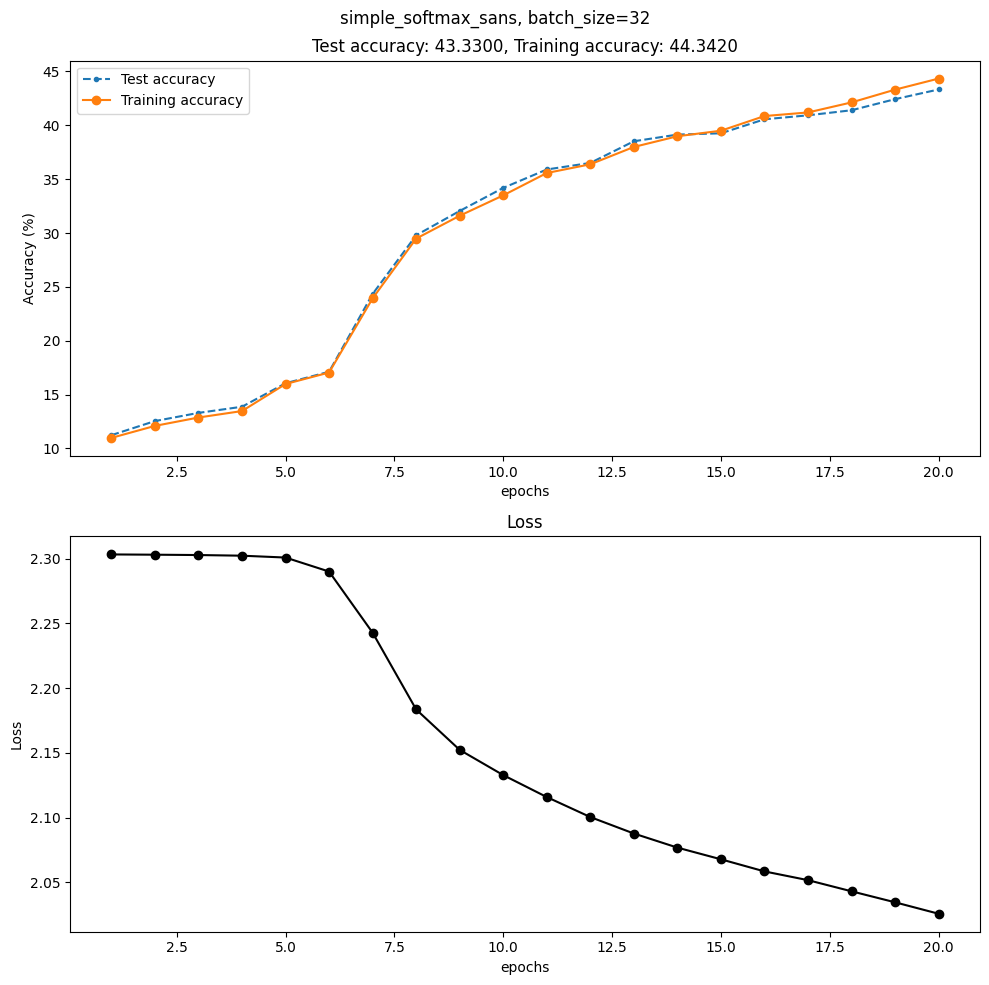

In [28]:
simple_softmax_net2_train = TrainEtPrecision(
    data_loader32,
    simple_softmax_net2, 
    criterion_CE,
    optimizer_SDG(simple_softmax_net2.parameters(), lr=0.001), 
    20, 
    "simple_softmax_sans"
    )

### **Influence du critère** :

#### *Création des modèles* :

In [29]:
simple_critere_net1 = S_Net(
    3,
    10,
    last_layer='log_softmax'
    )
simple_critere_net1 = simple_critere_net1.cuda()

simple_critere_net2 = S_Net(
    3,
    10,
    last_layer='log_softmax'
    )
simple_critere_net2 = simple_critere_net2.cuda()

#### *Entraînements et visualisation des performances, comparaison du temps de computation :*

###### net1 : CrossEntropy

EPOCH #1


C:\Users\ferdi\AppData\Local\Temp\ipykernel_36712\296086082.py:73: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.last(x)


[1, 8992] loss: 2.307
[1, 18016] loss: 2.301
[1, 27040] loss: 2.283
[1, 36064] loss: 2.182
[1, 45088] loss: 2.029
Accuracy of the network on the 50000 train images: 29.744 %
Accuracy of the network on the 10000 test images: 29.72 %
EPOCH #2
[2, 8992] loss: 1.916
[2, 18016] loss: 1.849
[2, 27040] loss: 1.802
[2, 36064] loss: 1.715
[2, 45088] loss: 1.691
Accuracy of the network on the 50000 train images: 40.894 %
Accuracy of the network on the 10000 test images: 40.92 %
EPOCH #3
[3, 8992] loss: 1.603
[3, 18016] loss: 1.583
[3, 27040] loss: 1.568
[3, 36064] loss: 1.533
[3, 45088] loss: 1.510
Accuracy of the network on the 50000 train images: 46.392 %
Accuracy of the network on the 10000 test images: 45.72 %
EPOCH #4
[4, 8992] loss: 1.474
[4, 18016] loss: 1.465
[4, 27040] loss: 1.421
[4, 36064] loss: 1.436
[4, 45088] loss: 1.406
Accuracy of the network on the 50000 train images: 48.502 %
Accuracy of the network on the 10000 test images: 47.72 %
EPOCH #5
[5, 8992] loss: 1.364
[5, 18016] los

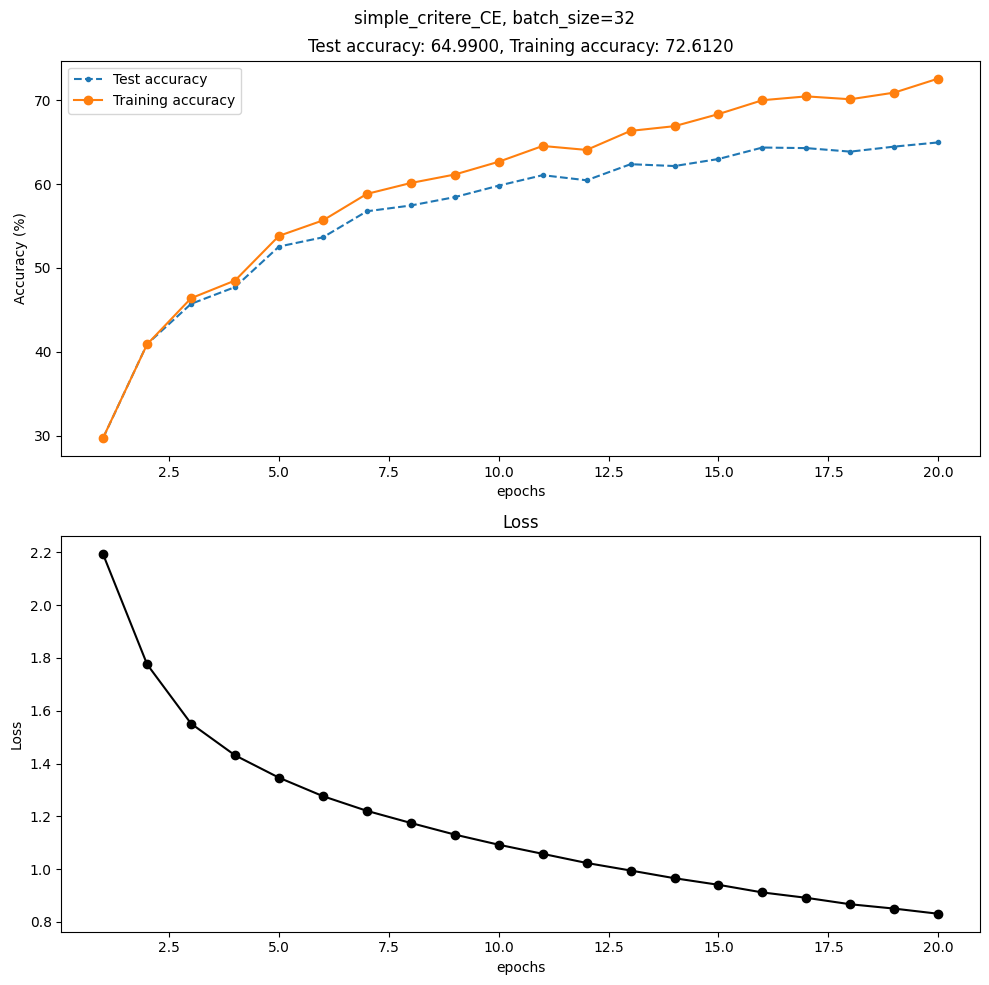

In [30]:
simple_critere_net1_train = TrainEtPrecision(
    data_loader32,
    simple_critere_net1, 
    criterion_CE,
    optimizer_SDG(simple_critere_net1.parameters(), lr=0.001), 
    20, 
    "simple_critere_CE"
    )

###### net2 : NegativeLogLikelyhood

EPOCH #1


C:\Users\ferdi\AppData\Local\Temp\ipykernel_36712\296086082.py:73: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.last(x)


[1, 8992] loss: 2.311
[1, 18016] loss: 2.309
[1, 27040] loss: 2.306
[1, 36064] loss: 2.301
[1, 45088] loss: 2.290
Accuracy of the network on the 50000 train images: 17.976 %
Accuracy of the network on the 10000 test images: 18.14 %
EPOCH #2
[2, 8992] loss: 2.166
[2, 18016] loss: 2.050
[2, 27040] loss: 1.967
[2, 36064] loss: 1.867
[2, 45088] loss: 1.786
Accuracy of the network on the 50000 train images: 36.79 %
Accuracy of the network on the 10000 test images: 37.2 %
EPOCH #3
[3, 8992] loss: 1.702
[3, 18016] loss: 1.663
[3, 27040] loss: 1.641
[3, 36064] loss: 1.625
[3, 45088] loss: 1.574
Accuracy of the network on the 50000 train images: 42.74 %
Accuracy of the network on the 10000 test images: 42.5 %
EPOCH #4
[4, 8992] loss: 1.555
[4, 18016] loss: 1.521
[4, 27040] loss: 1.522
[4, 36064] loss: 1.488
[4, 45088] loss: 1.468
Accuracy of the network on the 50000 train images: 47.07 %
Accuracy of the network on the 10000 test images: 47.15 %
EPOCH #5
[5, 8992] loss: 1.453
[5, 18016] loss: 1.

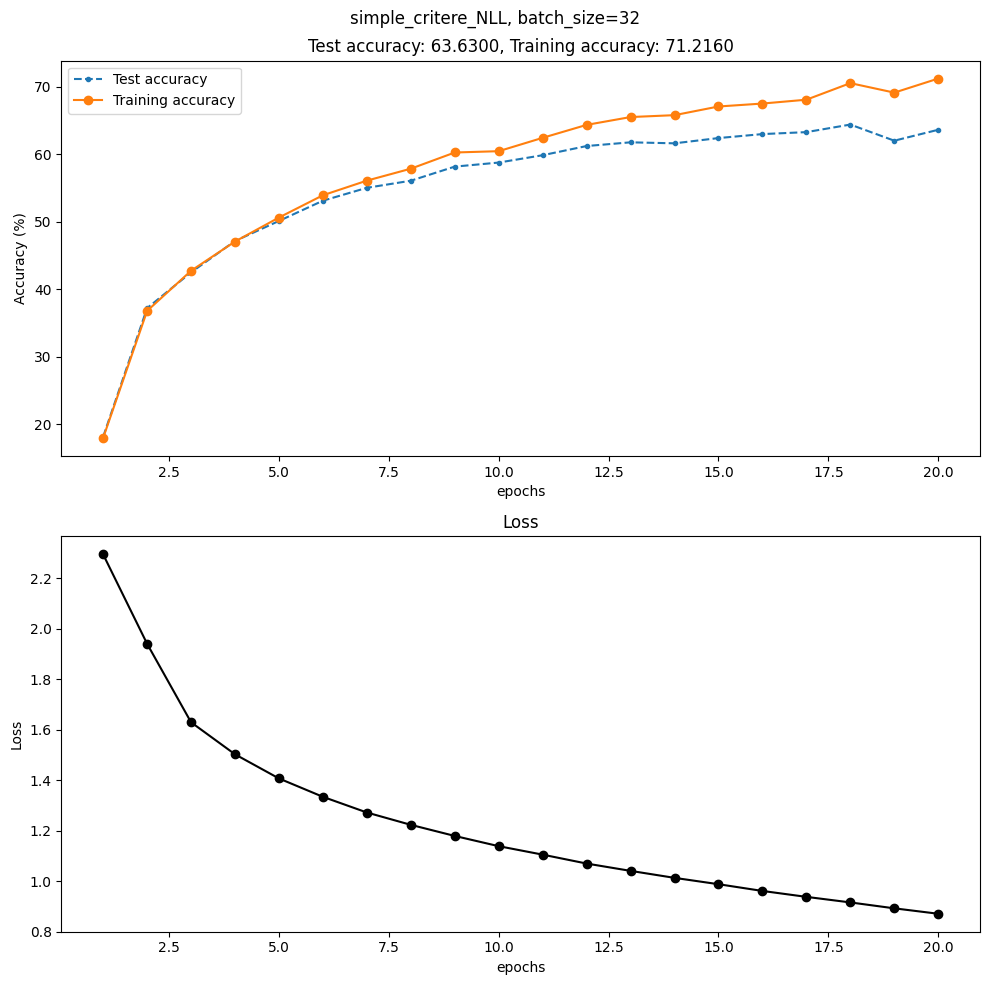

In [31]:
simple_critere_net2_train = TrainEtPrecision(
    data_loader32,
    simple_critere_net2, 
    criterion_NLL,
    optimizer_SDG(simple_critere_net2.parameters(), lr=0.001), 
    20, 
    "simple_critere_NLL"
    )

# Le modèle Simple Amélioré

On va maintenant travailler sur le dernier modèle mais en augmentant la taille des filtres, pour comprendre l'influence de ceci sur un modèle. On utilisera le batchnorm et le dropout tout comme dans le modèle Parkhi complet, pour obtenir les meilleurs performance et le moins d'overfiting.

### **Cross Entropy ou Negative LogLikelyhood ?**

EPOCH #1


C:\Users\ferdi\AppData\Local\Temp\ipykernel_36712\296086082.py:73: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.last(x)


[1, 8992] loss: 2.137
[1, 18016] loss: 1.693
[1, 27040] loss: 1.564
[1, 36064] loss: 1.452
[1, 45088] loss: 1.396
Accuracy of the network on the 50000 train images: 49.684 %
Accuracy of the network on the 10000 test images: 48.59 %
EPOCH #2
[2, 8992] loss: 1.312
[2, 18016] loss: 1.282
[2, 27040] loss: 1.269
[2, 36064] loss: 1.247
[2, 45088] loss: 1.218
Accuracy of the network on the 50000 train images: 57.954 %
Accuracy of the network on the 10000 test images: 57.02 %
EPOCH #3
[3, 8992] loss: 1.154
[3, 18016] loss: 1.142
[3, 27040] loss: 1.162
[3, 36064] loss: 1.126
[3, 45088] loss: 1.112
Accuracy of the network on the 50000 train images: 62.546 %
Accuracy of the network on the 10000 test images: 61.49 %
EPOCH #4
[4, 8992] loss: 1.088
[4, 18016] loss: 1.055
[4, 27040] loss: 1.077
[4, 36064] loss: 1.036
[4, 45088] loss: 1.046
Accuracy of the network on the 50000 train images: 65.304 %
Accuracy of the network on the 10000 test images: 63.83 %
EPOCH #5
[5, 8992] loss: 1.011
[5, 18016] los

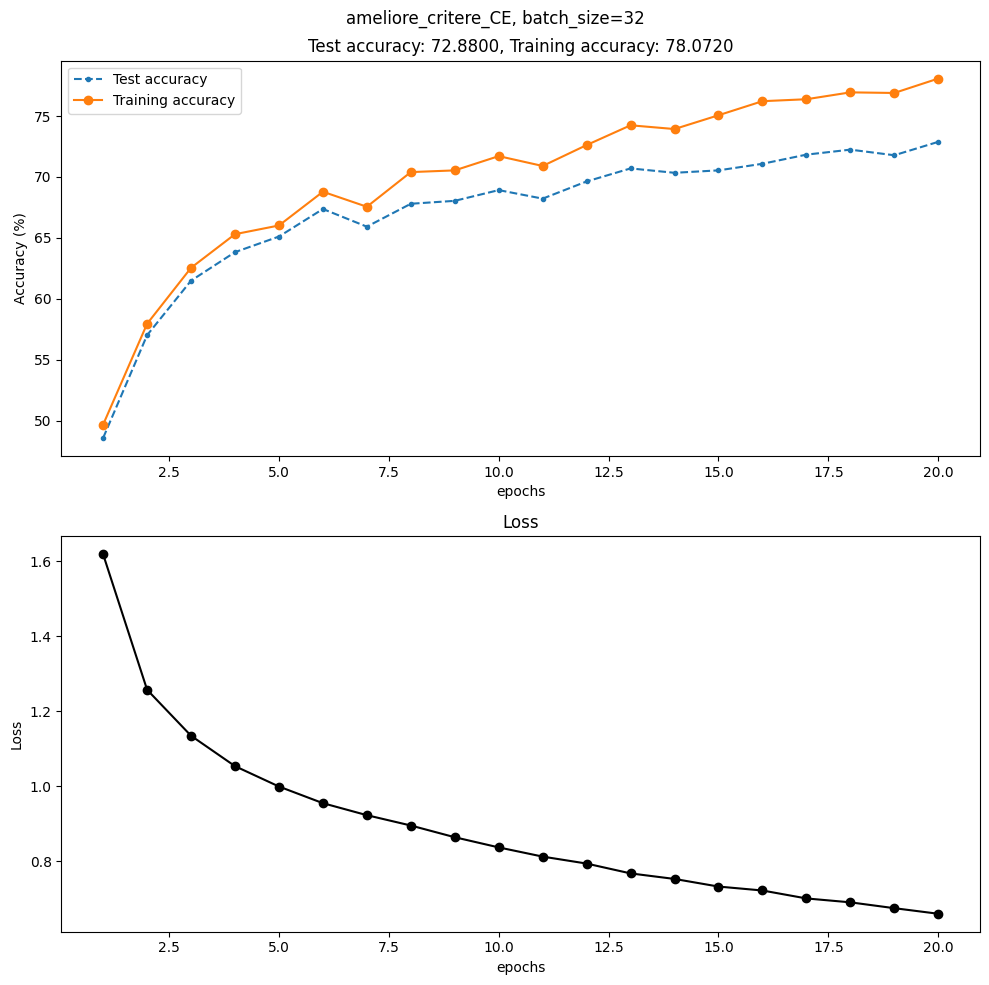

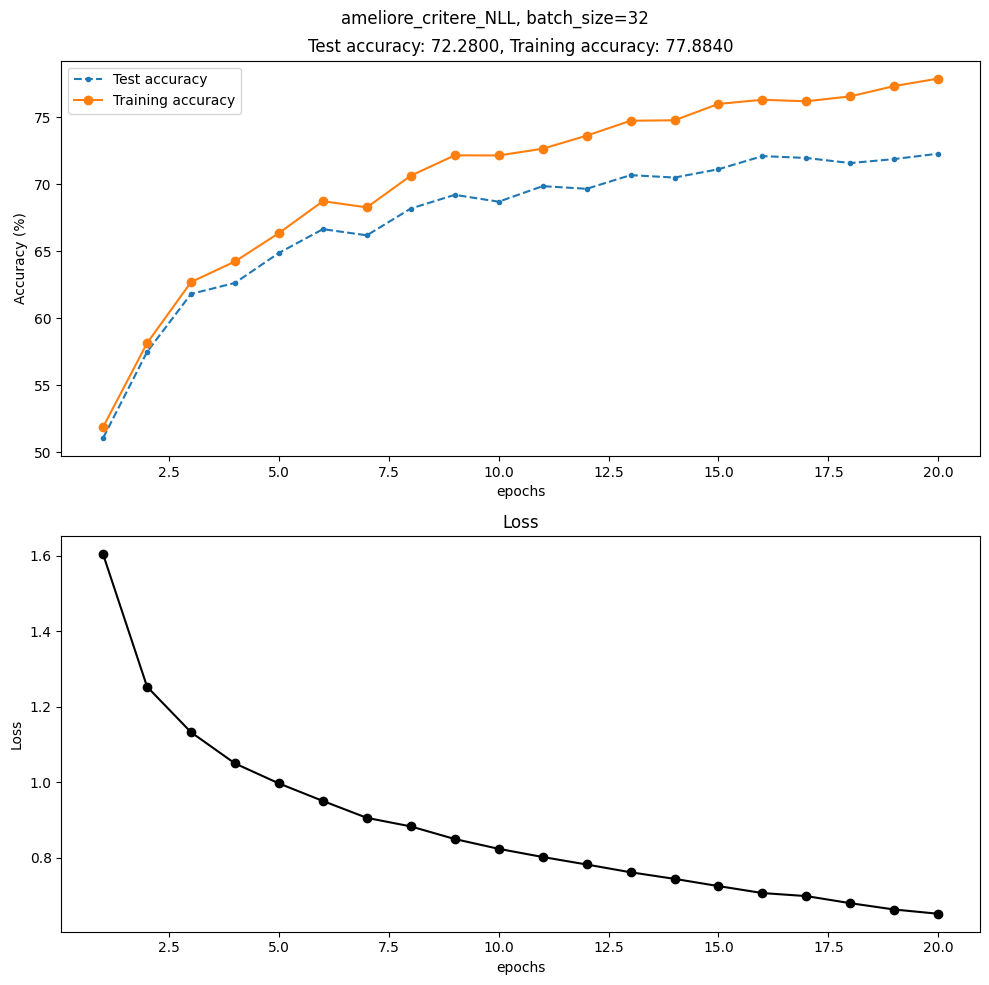

In [32]:
            # Création des modèles :

ameliore_critere_net1 = S_Net(
    3,
    10, 
    modele_ameliore='Yes',
    do_batchnorm='Yes',
    do_dropout='Yes',
    last_layer='log_softmax'
    )
ameliore_critere_net1 = ameliore_critere_net1.cuda()

ameliore_critere_net2 = S_Net(
    3,
    10, 
    modele_ameliore='Yes',
    do_batchnorm='Yes',
    do_dropout='Yes',
    last_layer='log_softmax'
    )
ameliore_critere_net2 = ameliore_critere_net2.cuda()

            # Entraînements :
    
ameliore_critere_net1_train = TrainEtPrecision(
    data_loader32, 
    ameliore_critere_net1, 
    criterion_CE,
    optimizer_SDG(ameliore_critere_net1.parameters(), lr=0.001), 
    20, 
    "ameliore_critere_CE"
    )

ameliore_critere_net2_train = TrainEtPrecision(
    data_loader32, 
    ameliore_critere_net2, 
    criterion_NLL,
    optimizer_SDG(ameliore_critere_net2.parameters(), lr=0.001), 
    20, 
    "ameliore_critere_NLL"
    )

### **Softmax ou Logsoftmax ?**

EPOCH #1


C:\Users\ferdi\AppData\Local\Temp\ipykernel_36712\296086082.py:73: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.last(x)


[1, 8992] loss: 2.306
[1, 18016] loss: 2.297
[1, 27040] loss: 2.276
[1, 36064] loss: 2.258
[1, 45088] loss: 2.227
Accuracy of the network on the 50000 train images: 28.358 %
Accuracy of the network on the 10000 test images: 28.94 %
EPOCH #2
[2, 8992] loss: 2.186
[2, 18016] loss: 2.158
[2, 27040] loss: 2.137
[2, 36064] loss: 2.126
[2, 45088] loss: 2.112
Accuracy of the network on the 50000 train images: 38.526 %
Accuracy of the network on the 10000 test images: 38.4 %
EPOCH #3
[3, 8992] loss: 2.080
[3, 18016] loss: 2.067
[3, 27040] loss: 2.052
[3, 36064] loss: 2.037
[3, 45088] loss: 2.027
Accuracy of the network on the 50000 train images: 46.834 %
Accuracy of the network on the 10000 test images: 46.97 %
EPOCH #4
[4, 8992] loss: 1.994
[4, 18016] loss: 1.990
[4, 27040] loss: 1.985
[4, 36064] loss: 1.973
[4, 45088] loss: 1.978
Accuracy of the network on the 50000 train images: 51.724 %
Accuracy of the network on the 10000 test images: 50.6 %
EPOCH #5
[5, 8992] loss: 1.953
[5, 18016] loss:

C:\Users\ferdi\AppData\Local\Temp\ipykernel_36712\296086082.py:73: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.last(x)


[1, 8992] loss: 2.126
[1, 18016] loss: 1.721
[1, 27040] loss: 1.570
[1, 36064] loss: 1.484
[1, 45088] loss: 1.434
Accuracy of the network on the 50000 train images: 50.386 %
Accuracy of the network on the 10000 test images: 50.11 %
EPOCH #2
[2, 8992] loss: 1.327
[2, 18016] loss: 1.291
[2, 27040] loss: 1.280
[2, 36064] loss: 1.242
[2, 45088] loss: 1.231
Accuracy of the network on the 50000 train images: 58.164 %
Accuracy of the network on the 10000 test images: 57.12 %
EPOCH #3
[3, 8992] loss: 1.181
[3, 18016] loss: 1.138
[3, 27040] loss: 1.133
[3, 36064] loss: 1.129
[3, 45088] loss: 1.127
Accuracy of the network on the 50000 train images: 62.934 %
Accuracy of the network on the 10000 test images: 60.8 %
EPOCH #4
[4, 8992] loss: 1.065
[4, 18016] loss: 1.087
[4, 27040] loss: 1.067
[4, 36064] loss: 1.067
[4, 45088] loss: 1.026
Accuracy of the network on the 50000 train images: 64.214 %
Accuracy of the network on the 10000 test images: 62.6 %
EPOCH #5
[5, 8992] loss: 1.004
[5, 18016] loss:

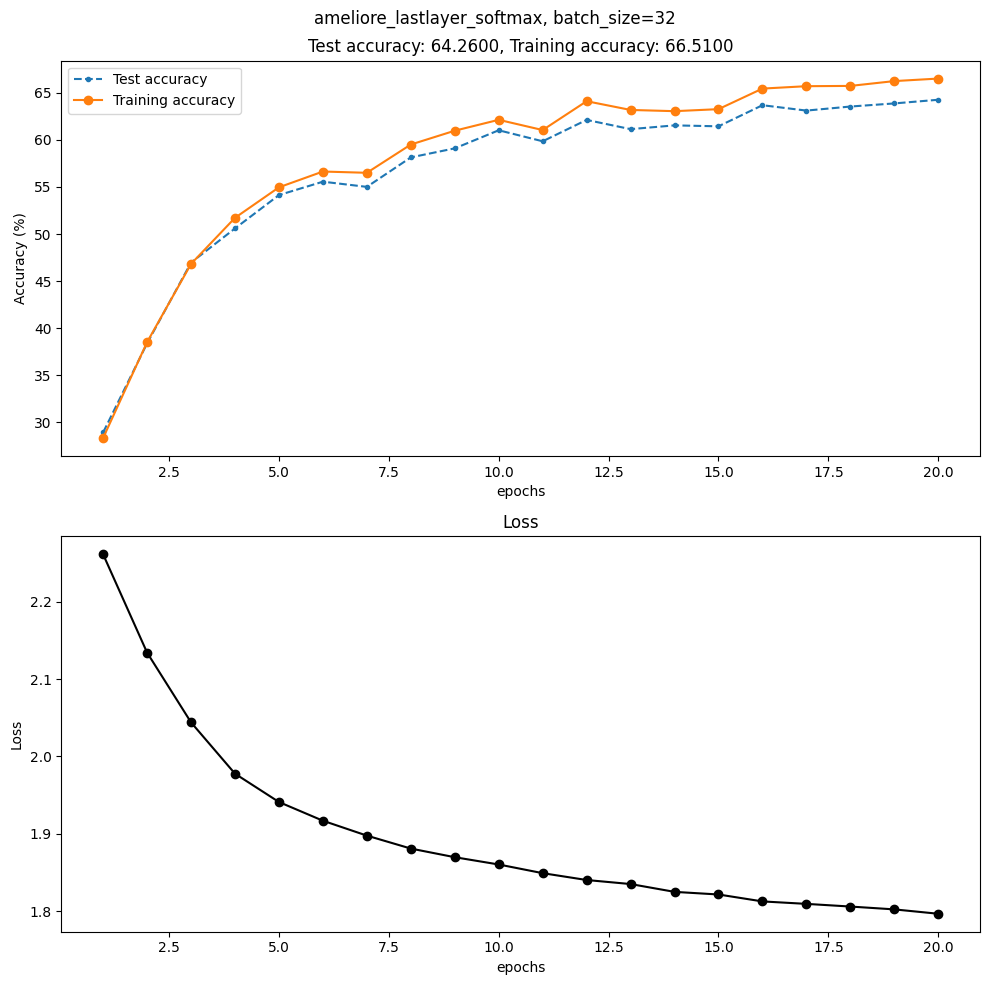

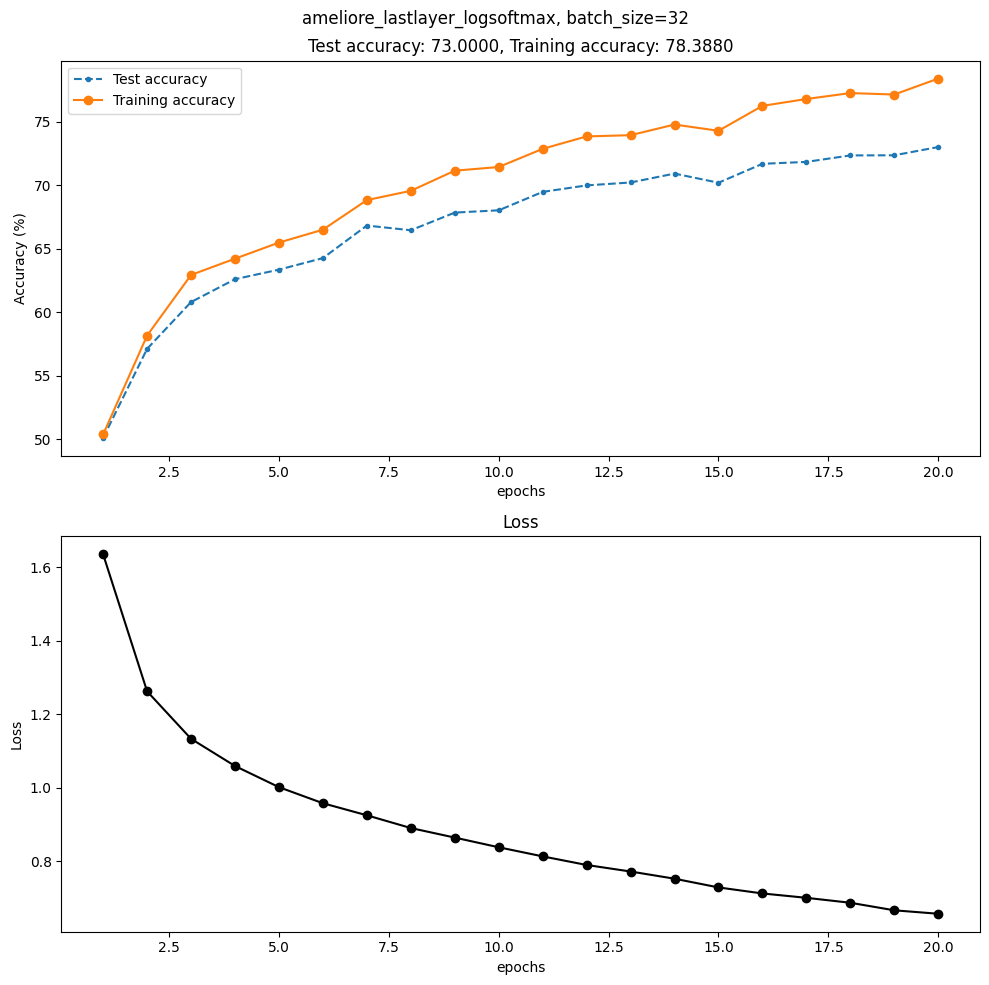

In [33]:
            # Création des modèles :

ameliore_lastlayer_net1 = S_Net(
    3,
    10, 
    modele_ameliore='Yes',
    do_batchnorm='Yes',
    do_dropout='Yes',
    last_layer='softmax'
    )
ameliore_lastlayer_net1 = ameliore_lastlayer_net1.cuda()

ameliore_lastlayer_net2 = S_Net(
    3,
    10, 
    modele_ameliore='Yes',
    do_batchnorm='Yes',
    do_dropout='Yes',
    last_layer='log_softmax'
    )
ameliore_lastlayer_net2 = ameliore_lastlayer_net2.cuda()

            # Entraînements :
    
ameliore_lastlayer_net1_train = TrainEtPrecision(
    data_loader32, 
    ameliore_lastlayer_net1, 
    criterion_CE,
    optimizer_SDG(ameliore_lastlayer_net1.parameters(), lr=0.001), 
    20, 
    "ameliore_lastlayer_softmax"
    )

ameliore_lastlayer_net2_train = TrainEtPrecision(
    data_loader32, 
    ameliore_lastlayer_net2, 
    criterion_CE,
    optimizer_SDG(ameliore_lastlayer_net2.parameters(), lr=0.001), 
    20, 
    "ameliore_lastlayer_logsoftmax"
    )

### **Ajouter plus d'epochs ?**

EPOCH #1


C:\Users\ferdi\AppData\Local\Temp\ipykernel_36712\296086082.py:73: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.last(x)


[1, 8992] loss: 2.166
[1, 18016] loss: 2.086
[1, 27040] loss: 2.052
[1, 36064] loss: 2.025
[1, 45088] loss: 2.010
Accuracy of the network on the 50000 train images: 44.964 %
Accuracy of the network on the 10000 test images: 44.93 %
EPOCH #2
[2, 8992] loss: 1.987
[2, 18016] loss: 1.982
[2, 27040] loss: 1.972
[2, 36064] loss: 1.962
[2, 45088] loss: 1.948
Accuracy of the network on the 50000 train images: 52.016 %
Accuracy of the network on the 10000 test images: 51.11 %
EPOCH #3
[3, 8992] loss: 1.953
[3, 18016] loss: 1.935
[3, 27040] loss: 1.938
[3, 36064] loss: 1.937
[3, 45088] loss: 1.927
Accuracy of the network on the 50000 train images: 53.018 %
Accuracy of the network on the 10000 test images: 51.9 %
EPOCH #4
[4, 8992] loss: 1.923
[4, 18016] loss: 1.928
[4, 27040] loss: 1.912
[4, 36064] loss: 1.905
[4, 45088] loss: 1.909
Accuracy of the network on the 50000 train images: 57.592 %
Accuracy of the network on the 10000 test images: 55.89 %
EPOCH #5
[5, 8992] loss: 1.896
[5, 18016] loss

C:\Users\ferdi\AppData\Local\Temp\ipykernel_36712\296086082.py:73: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.last(x)


[1, 8992] loss: 1.741
[1, 18016] loss: 1.480
[1, 27040] loss: 1.397
[1, 36064] loss: 1.355
[1, 45088] loss: 1.277
Accuracy of the network on the 50000 train images: 57.07 %
Accuracy of the network on the 10000 test images: 56.32 %
EPOCH #2
[2, 8992] loss: 1.168
[2, 18016] loss: 1.174
[2, 27040] loss: 1.129
[2, 36064] loss: 1.123
[2, 45088] loss: 1.091
Accuracy of the network on the 50000 train images: 63.24 %
Accuracy of the network on the 10000 test images: 61.57 %
EPOCH #3
[3, 8992] loss: 1.027
[3, 18016] loss: 1.022
[3, 27040] loss: 1.035
[3, 36064] loss: 1.010
[3, 45088] loss: 1.005
Accuracy of the network on the 50000 train images: 66.482 %
Accuracy of the network on the 10000 test images: 65.16 %
EPOCH #4
[4, 8992] loss: 0.958
[4, 18016] loss: 0.949
[4, 27040] loss: 0.941
[4, 36064] loss: 0.930
[4, 45088] loss: 0.935
Accuracy of the network on the 50000 train images: 69.53 %
Accuracy of the network on the 10000 test images: 67.1 %
EPOCH #5
[5, 8992] loss: 0.885
[5, 18016] loss: 0

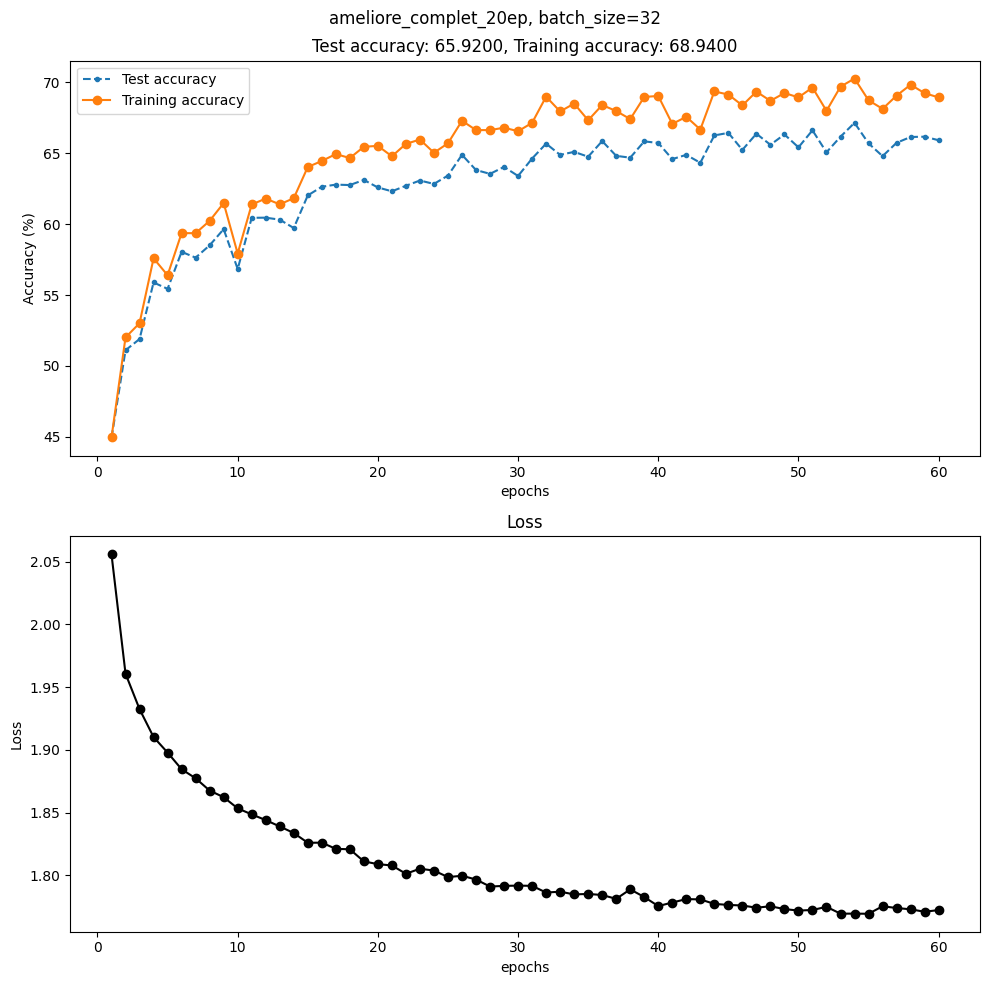

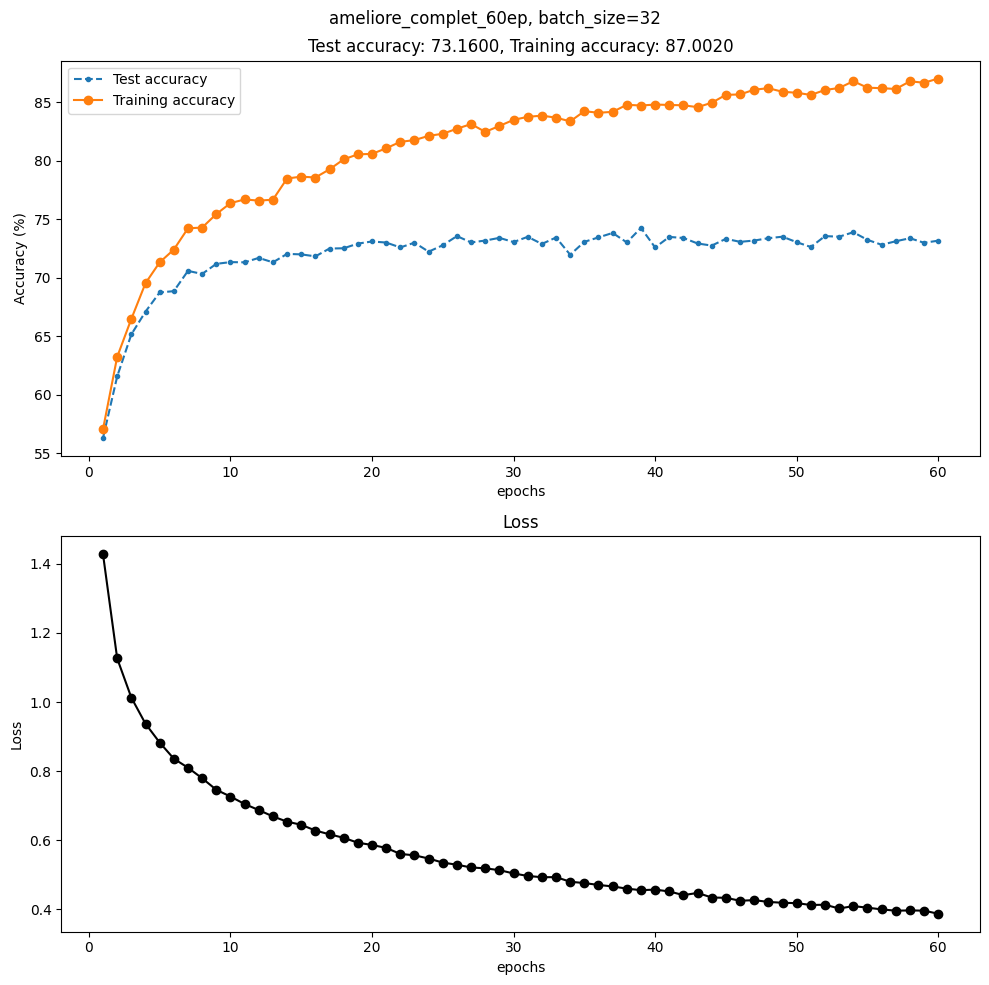

In [34]:
            # Création des modèles :

ameliore_complet_20ep = S_Net(
    3,
    10, 
    modele_ameliore='Yes',
    do_batchnorm='Yes',
    do_dropout='Yes',
    last_layer='softmax'
    )
ameliore_complet_20ep = ameliore_complet_20ep.cuda()

ameliore_complet_60ep = S_Net(
    3,
    10, 
    modele_ameliore='Yes',
    do_batchnorm='Yes',
    do_dropout='Yes',
    last_layer='log_softmax'
    )
ameliore_complet_60ep = ameliore_complet_60ep.cuda()

            # Entraînements :
    
ameliore_complet_20ep_train = TrainEtPrecision(
    data_loader32, 
    ameliore_complet_20ep, 
    criterion_CE,
    optimizer_ADAM(ameliore_complet_20ep.parameters(), lr=0.001), 
    60, 
    "ameliore_complet_20ep"
    )

ameliore_complet_60ep_train = TrainEtPrecision(
    data_loader32, 
    ameliore_complet_60ep, 
    criterion_CE,
    optimizer_ADAM(ameliore_complet_60ep.parameters(), lr=0.001), 
    60, 
    "ameliore_complet_60ep"
    )

# CIFAR-100

On va entraîner et tester le modèle Parkhi sur une base de donnée avec 100 classes, CIFAR-100, avec toujours un training set de 50000 images et un testing set de 10000 images rgb 32 par 32.

### La base de donnée :

100.0%


Extracting ./data\cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Dataset CIFAR100
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dataset CIFAR100
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


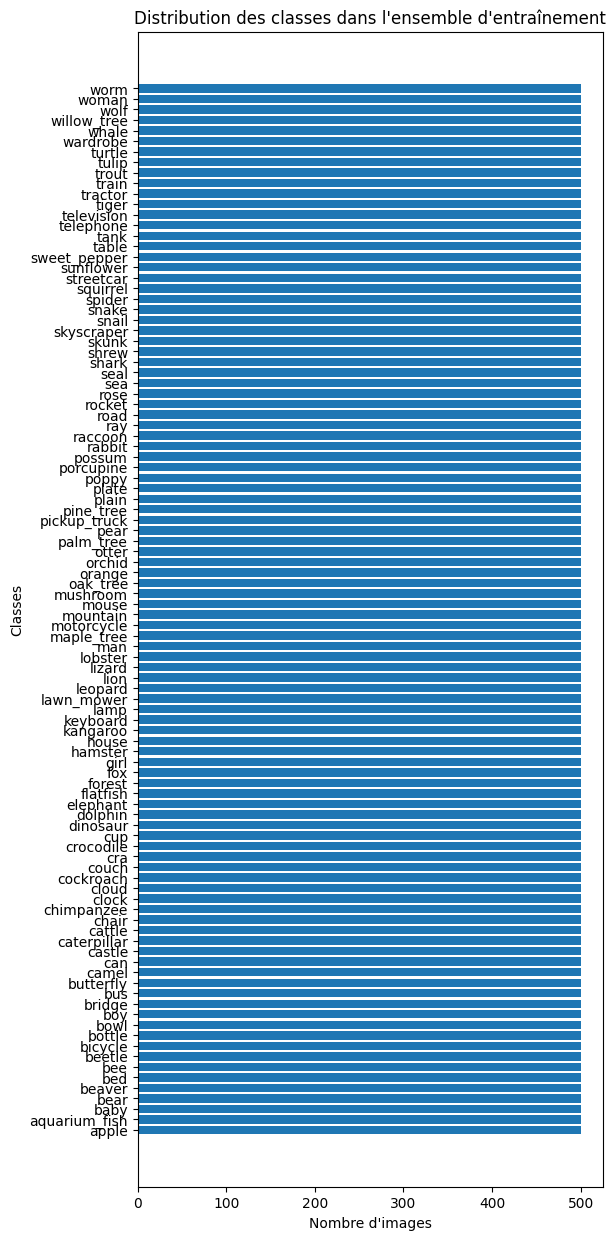

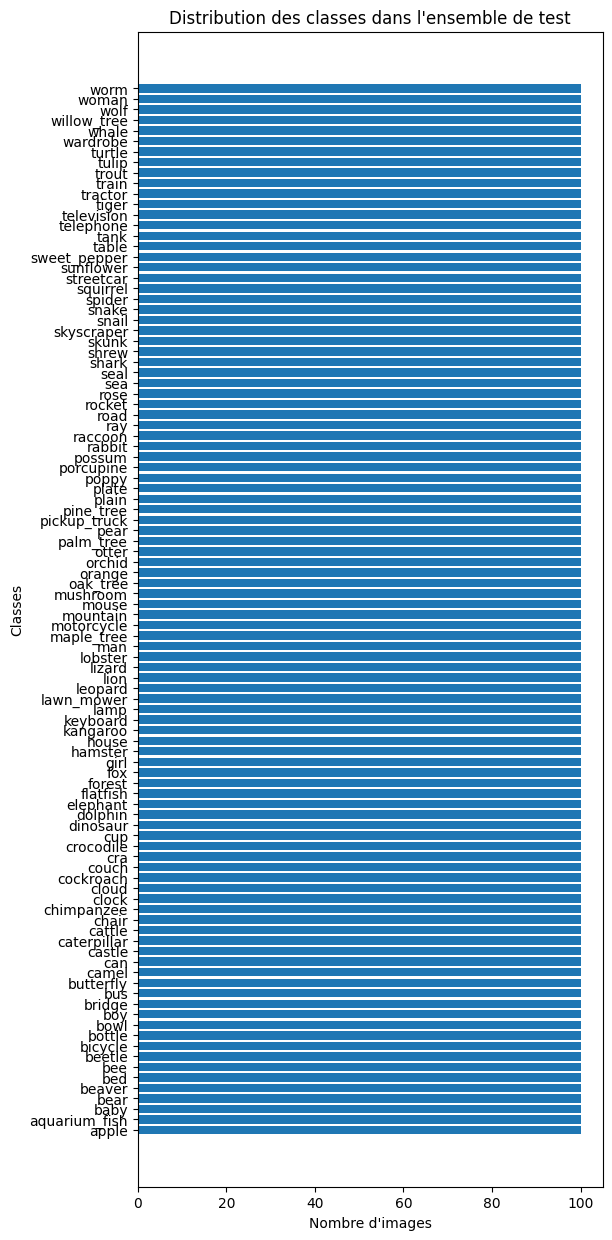

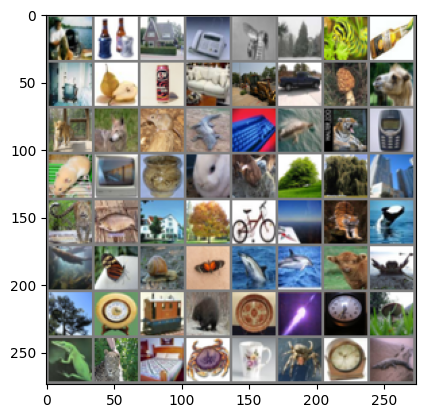

batch_size = 64 et dimension d'une image = torch.Size([3, 32, 32])
flatfish	bottle	house	telephone	bee	pine_tree	caterpillar	bottle
television	pear	can	couch	tractor	pickup_truck	mushroom	camel
leopard	wolf	mouse	crocodile	keyboard	dolphin	tiger	telephone
hamster	television	bowl	rabbit	cattle	oak_tree	willow_tree	skyscraper
leopard	trout	house	oak_tree	bicycle	plain	tiger	whale
otter	butterfly	snail	butterfly	dolphin	dolphin	cattle	cra
pine_tree	clock	streetcar	porcupine	plate	rocket	clock	mushroom
lizard	leopard	bed	cra	cup	spider	clock	crocodile


In [35]:
# Charger la base de donnée :
cifar100_loader64 = DataLoader(64, cifar=100)
print(cifar100_loader64.trainset)
print(cifar100_loader64.testset)
### Afficher la répartition des données en fonction des classes :
cifar100_loader64.show_class_distribution('train')
cifar100_loader64.show_class_distribution('test')
# Afficher les images et les labels d'un batch :
cifar100_loader64.show_one_random_batch()

### **Entraînement avec Parkhi complet** :

in :
torch.Size([64, 3, 32, 32])
## Stage 1
## conv11 :
torch.Size([64, 32, 32, 32])
## conv12 :
torch.Size([64, 32, 32, 32])
## maxpool :
torch.Size([64, 32, 16, 16])
## Stage 2
## conv21 :
torch.Size([64, 64, 16, 16])
## conv22 :
torch.Size([64, 64, 16, 16])
## maxpool :
torch.Size([64, 64, 8, 8])
## Stage 3
## conv31 :
torch.Size([64, 128, 8, 8])
## conv32 :
torch.Size([64, 128, 8, 8])
## conv33 :
torch.Size([64, 128, 8, 8])
## maxpool :
torch.Size([64, 128, 4, 4])
## Stage 4
## conv41 :
torch.Size([64, 256, 4, 4])
## conv42 :
torch.Size([64, 256, 4, 4])
## conv43 :
torch.Size([64, 256, 4, 4])
## maxpool :
torch.Size([64, 256, 2, 2])
## Stage 5
## conv51 :
torch.Size([64, 256, 2, 2])
## conv52 :
torch.Size([64, 256, 2, 2])
## conv53 :
torch.Size([64, 256, 2, 2])
## maxpool :
torch.Size([64, 256, 1, 1])
## flatten :
torch.Size([64, 256])
## Stage 6
## fully connected 6 :
torch.Size([64, 4096])
## Stage 7
## fully connected 7 :
torch.Size([64, 4096])
## dropout (si Yes) :
torch.Size([

<string>:1: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\ferdi\AppData\Local\Temp\ipykernel_36712\1491462521.py:127: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.last(x)


[1, 8960] loss: 4.579
[1, 17984] loss: 4.504
[1, 27008] loss: 4.387
[1, 36032] loss: 4.238
[1, 45056] loss: 4.083
Accuracy of the network on the 50000 train images: 10.302 %
Accuracy of the network on the 10000 test images: 10.05 %
EPOCH #2
[2, 8960] loss: 3.797
[2, 17984] loss: 3.703
[2, 27008] loss: 3.583
[2, 36032] loss: 3.509
[2, 45056] loss: 3.446
Accuracy of the network on the 50000 train images: 20.322 %
Accuracy of the network on the 10000 test images: 19.23 %
EPOCH #3
[3, 8960] loss: 3.238
[3, 17984] loss: 3.131
[3, 27008] loss: 3.026
[3, 36032] loss: 2.981
[3, 45056] loss: 2.930
Accuracy of the network on the 50000 train images: 30.58 %
Accuracy of the network on the 10000 test images: 28.17 %
EPOCH #4
[4, 8960] loss: 2.612
[4, 17984] loss: 2.603
[4, 27008] loss: 2.589
[4, 36032] loss: 2.564
[4, 45056] loss: 2.523
Accuracy of the network on the 50000 train images: 38.354 %
Accuracy of the network on the 10000 test images: 34.17 %
EPOCH #5
[5, 8960] loss: 2.228
[5, 17984] loss

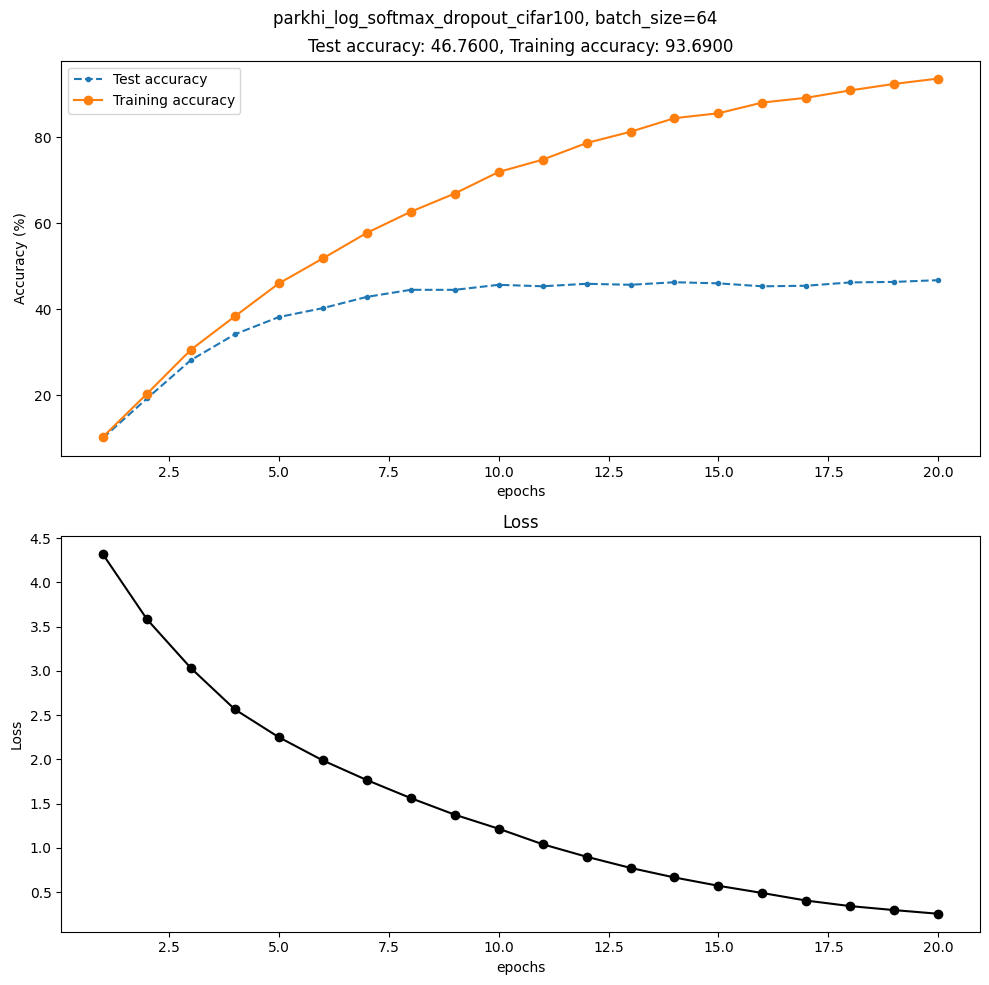

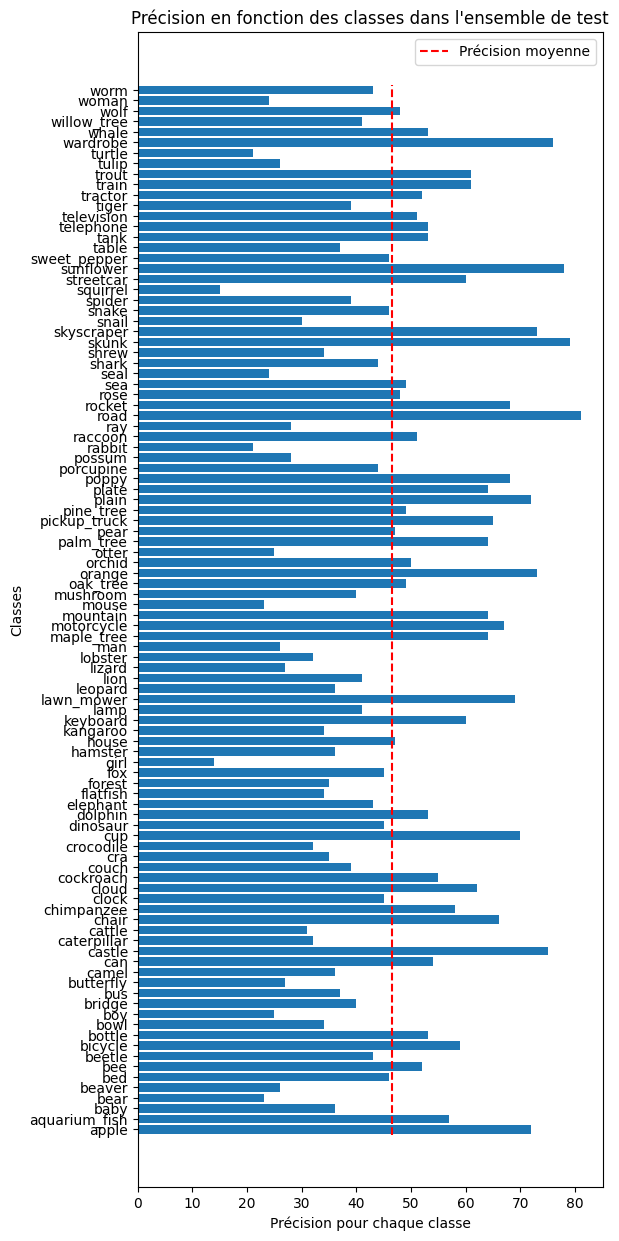

In [36]:
parkhi_net_cifar100 = P_Net(
    3, 
    100, 
    last_layer='log_softmax', 
    do_dropout='yes'
    )
parkhi_net_cifar100 = parkhi_net_cifar100.cuda()

images, labels = cifar100_loader64.get_random_train_batch()
parkhi_net_cifar100.size_debug(images.cuda())

parkhi_net_cifar100_train = TrainEtPrecision(
    cifar100_loader64,
    parkhi_net_cifar100,
    criterion_CE, 
    optimizer_SDG(parkhi_net_cifar100.parameters(), lr=0.001),
    20,
    "parkhi_log_softmax_dropout_cifar100"
    )

parkhi_net_cifar100_train.plot_accuracy_for_each_classes()

# *Références :*

● Deep Face Recognition - O. M. Parkhi - https://www.robots.ox.ac.uk/~vgg/publications/2015/Parkhi15/parkhi15.pdf
